Estimating likelihood of death as a function of days since COVID-19 diagnosis
============================

Look, this is really sloppy, has some kind of ad-hoc smoothing weights, and doesn't have enough comments.

I'm going to put it up, but with some strong caveats that it's not really ready for public consumption yet.

Enjoy!

In [49]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from datetime import datetime, timedelta
import nbconvert

In [50]:
fname = "covid-19-data/us-counties.csv"
pop_data_fname = "us-census-data/county_data.csv"

In [51]:
county_pops = {}
csv_reader = csv.DictReader(open(pop_data_fname, 'r', newline='', encoding='ISO-8859-1'))
for entry in csv_reader:
    # print(entry['STNAME'] + " - " + entry['CTYNAME'])
    state_entry = county_pops.get(entry['STNAME'], {})
    county_name = entry["CTYNAME"].replace(" County", "")
    state_entry[county_name] = float(entry["POPESTIMATE2019"])
    county_pops[entry['STNAME']] = state_entry
county_pops["New York"]["New York City"] = 8.399e6
print("LA -> " + str(county_pops["California"]["Los Angeles"]))
print("Catoosa -> " + str(county_pops["Georgia"]["Catoosa"]))
print("Grimes -> " + str(county_pops["Texas"]["Grimes"]))

LA -> 10039107.0
Catoosa -> 67580.0
Grimes -> 28880.0


In [52]:
population_drop_thresh = 30000
csv_reader = csv.DictReader(open(fname))
data = []
for entry in csv_reader:
    if entry['county'].lower() == "unknown":
        continue
    raw_pop = county_pops.get(entry['state'], {}).get(entry['county'], 0.0)
    if True:
        if raw_pop <= 0.0 or raw_pop < population_drop_thresh:
            continue
        entry['population'] = raw_pop
    entry['county'] = entry['state'] + " - " + entry['county']
    data.append(entry)


In [53]:
def entry_to_days(entry):
    """Converts a YYYY-mm-dd date into an integer with 0 being 2020-01-01"""
    if entry is None:
        return None
    d1 = datetime.strptime(entry['date'], "%Y-%m-%d")
    d0 = datetime.strptime("2020-01-01", "%Y-%m-%d")
    return(d1 - d0).days

def date_to_daynum(date):
    """Converts a YYYY-mm-dd date into an integer with 0 being 2020-01-01"""
    if date is None:
        return None
    d1 = datetime.strptime(date, "%Y-%m-%d")
    d0 = datetime.strptime("2020-01-01", "%Y-%m-%d")
    return(d1 - d0).days

def date_from_daynum(daynum):
    return datetime.strptime("2020-01-01", "%Y-%m-%d") + timedelta(days=daynum)
    

In [54]:
today = datetime.now().strftime("%Y-%m-%d")
today, date_to_daynum(today)

('2022-03-18', 807)

In [55]:
data[0]

{'date': '2020-01-21',
 'county': 'Washington - Snohomish',
 'state': 'Washington',
 'fips': '53061',
 'cases': '1',
 'deaths': '0',
 'population': 822083.0}

In [56]:
# Now we extract data for all counties in this state
counties = {}
for d in data:
    l = counties.get(d['county'], [])
    val = float(d["cases"])
    other_val = float(d["deaths"])
    l.append([entry_to_days(d), val, other_val])
    counties[d['county']] = l
for county in counties:
    counties[county] = sorted(counties[county])

In [57]:
[k for k in counties.keys()][0], counties[[k for k in counties.keys()][0]][:3]

('Washington - Snohomish', [[20, 1.0, 0.0], [21, 1.0, 0.0], [22, 1.0, 0.0]])

In [58]:
[k for k in counties.keys()][0], counties[[k for k in counties.keys()][0]][-3:]

('Washington - Snohomish',
 [[804, 147993.0, 1085.0], [805, 148174.0, 1093.0], [806, 148174.0, 1093.0]])

In [59]:
changes = {}
smoothing = 1
for county in counties:
    ds = [e[2] for e in counties[county]]
    cs = [e[1] for e in counties[county]]
    ts = [e[0] for e in counties[county]]
    d_rates = [ds[t] - ds[t-smoothing] for t in range(smoothing, len(ds))]
    c_rates = [cs[t] - cs[t-smoothing] for t in range(smoothing, len(cs))]
    changes[county] = [[ts[smoothing+i], c_rates[i], d_rates[i]] for i in range(len(d_rates))]

In [60]:
def mat_stacks_for_county(county, window=30, startdate=None, enddate=None):
    start, end = date_to_daynum(startdate), date_to_daynum(enddate)
    first_seen = None
    last_seen = None
    lhs = []
    rhs = []
    for e in changes[county]:
        t = e[0]
        d = e[2]
        if d < 0 or (start is not None and t < start):
            continue
        if end is not None and t > end:
            continue
        first_seen = first_seen or t
        last_seen = last_seen or t
        v = [0 for i in range(window)]
        denom = max(d, 100)
        for e2 in changes[county]:
            idx = t - e2[0]
            if idx >= window or idx < 0:
                continue
            v[idx] = e2[1]/denom
            first_seen = min(first_seen, min(d, e2[0]))
            last_seen = max(last_seen, max(d, e2[0]))
        lhs.append([d/denom])
        rhs.append(v)
    return (np.array(lhs), np.array(rhs), first_seen, last_seen)

In [61]:
v,m, f, l = mat_stacks_for_county("New York - New York City", enddate="2021-12-01")

In [62]:
v.shape, m.shape, f, l

((628, 1), (628, 30), 14.0, 1221.0)

In [63]:
v,m, f, l = mat_stacks_for_county("New York - New York City", enddate="2020-05-01")
v.shape, m.shape, f, l

((61, 1), (61, 30), 1.0, 1221.0)

In [64]:
c = np.dot(np.linalg.pinv(m), v)

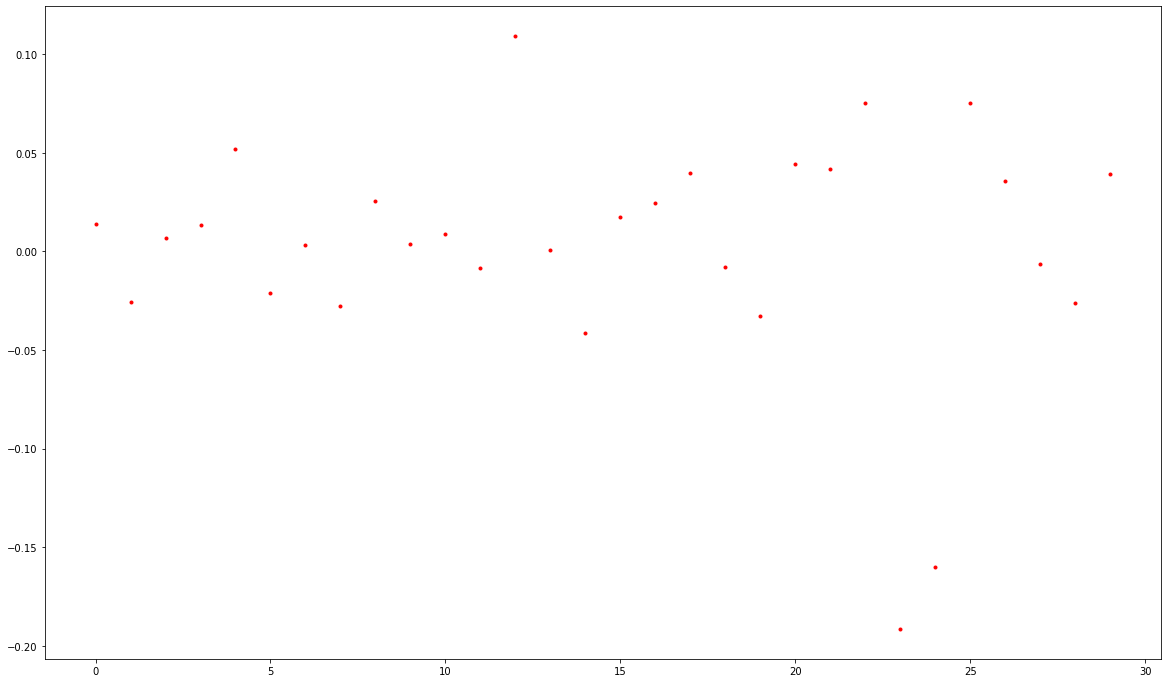

In [65]:
plt.plot([i for i in range(len(c))], c, 'r.')

In [66]:
np.array([])

array([], dtype=float64)

In [67]:
np.hstack([np.eye(3), np.eye(3)]), np.hstack([np.zeros((1,1)), np.zeros((1,1))])

(array([[1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1.]]),
 array([[0., 0.]]))

In [68]:
def giant_matrix_system(window=120, smooth_weight=500, end_smooth=25000, state=None, startdate=None, enddate=None):
    v_accum = None
    m_accum = None
    first_seen = None
    last_seen = None
    for county in counties.keys():
        if state is not None and state not in county.split(" - ")[0]:
            continue
        v,m, first, last = mat_stacks_for_county(county, window=window, startdate=startdate, enddate=enddate)
        if v.shape[0] == 0 or v.shape[1] == 0 or m.shape[0] == 0 or m.shape[1] == 0:
            continue
        if v_accum is None:
            v_accum = np.copy(v)
            m_accum = np.copy(m)
            continue
        v_accum = np.vstack([v_accum, v])
        m_accum = np.vstack([m_accum, m])
        if first_seen is None:
            first_seen = first
        if last_seen is None:
            last_seen = last
        first_seen = min(first_seen, first)
        last_seen = max(last_seen, last)
    for idx in range(1, window):
        row = np.zeros((1, window))
        v = np.zeros((1,1))
        row[0, idx] = smooth_weight
        row[0, idx - 1] = -smooth_weight
        v_accum = np.vstack([v_accum, v])
        m_accum = np.vstack([m_accum, row])
    v_accum = np.vstack([v_accum, np.zeros((2,1))])
    last_rows = np.zeros((2, window))
    last_rows[0, 0] = end_smooth
    last_rows[1, -1] = end_smooth
    m_accum = np.vstack([m_accum, last_rows])
    print(date_from_daynum(first_seen))
    print(date_from_daynum(last_seen))
    print(startdate)
    print(enddate)
    return (v_accum, m_accum)

This is the part you came here for
==========================

$X$ axis is "days since COVID-19 diagnosis"

$Y$ axis is "probability of entering the death statistics on that day"

Was planning on using this as a component for forecasting, but, haven't gotten around to it

In [69]:
def solve_state(state, window=120, smooth_weight=2000, end_smooth=40000, startdate=None, enddate=None):
    (v, m) = giant_matrix_system(window=window, smooth_weight=smooth_weight, end_smooth=end_smooth, state=state,
                                startdate=startdate, enddate=enddate)
    print("made matrix system " + str((v.shape, m.shape)))
    c = np.dot(np.linalg.pinv(m), v)
    print("Solved matrix system")
    plt.plot([i for i in range(len(c))], c, 'r-')
    print("sum(c) is " + str(sum(c)))
    print("expected days is " + str(sum([i * c[i] for i in range(len(c))]) / sum(c)))
    return c

In [70]:
def plot_predictions(state, window=120, smooth_weight=2000, end_smooth=40000, holdout_after=None, holdout_before=None):
    if holdout_after is not None:
        print("holding out data after " + holdout_after)
    conv = solve_state(state, window=window, smooth_weight=smooth_weight, end_smooth=end_smooth, startdate=holdout_before, enddate = holdout_after)
    plt.show()
    # print(conv.shape)
    # print(len(conv))
    phi = 0.5 * (1 + np.sqrt(5.0))
    plt.rcParams['figure.figsize'] = [20,int(20/phi)]
    deaths = {}
    cases = {}
    for county in counties.keys():
        if state is not None and state not in county.split(" - ")[0]:
            continue
        for e in changes[county]:
            t = e[0]
            county_cases = e[1]
            county_deaths = e[2]
            deaths[t] = deaths.get(t, 0) + county_deaths
            cases[t] = cases.get(t, 0) + county_cases
    t_min = min(cases.keys()) + len(conv)
    t_max = max(cases.keys()) + len(conv)
    predicted = [0 for i in range(t_min, t_max)]
    for t in range(t_min, t_max):
        for t_delta in range(len(conv)):
            predicted[t - t_min] += cases.get(t - t_delta, 0) * conv[t_delta][0]
    ts = sorted([t for t in deaths.keys()])
    plt.plot(ts, [deaths[t] for t in ts], 'k-')
    plt.plot([t for t in range(t_min, t_max)], predicted, 'b-.')
    plt.show()
    plt.plot(ts[-100:], [deaths[t] for t in ts[-100:]], 'k-')
    num_pts = 100 + len(conv)
    plt.plot([t for t in range(t_min, t_max)][-num_pts:], predicted[-num_pts:], 'b-.')
    plt.show()
    plt.plot(ts[-50:], [deaths[t] for t in ts[-50:]], 'k-')
    num_pts = 50 + len(conv)
    drop_pts = len(conv) - 14
    plt.plot([t for t in range(t_min, t_max)][-num_pts:][:(-drop_pts)], predicted[-num_pts:][:(-drop_pts)], 'b-.')
    today = datetime.now().strftime("%Y-%m-%d")
    print("Today's date, " + today + " is day number " + str(date_to_daynum(today)))

2020-01-01 00:00:00
2022-07-19 00:00:00
None
2021-12-01
made matrix system ((29517, 1), (29517, 120))
Solved matrix system
sum(c) is [0.01361801]
expected days is [34.74910073]


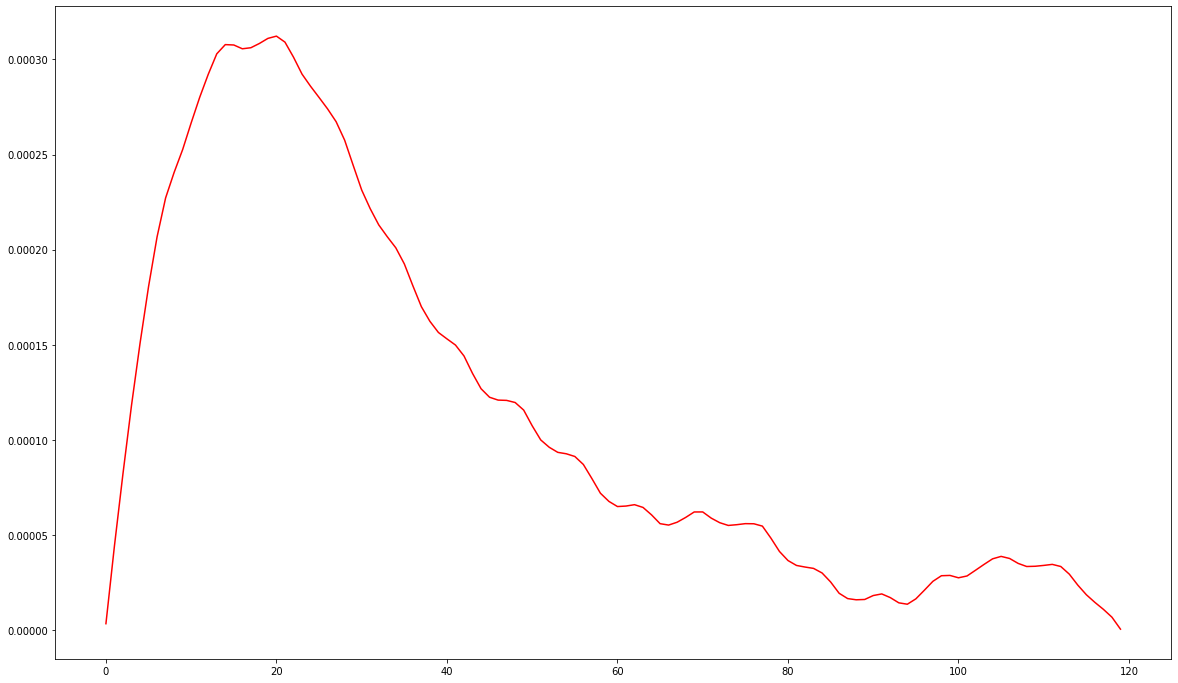

In [71]:
c_cal = solve_state("California", smooth_weight=10000, enddate="2021-12-01")

2020-01-01 00:00:00
2021-12-01 00:00:00
None
2021-12-01
made matrix system ((33771, 1), (33771, 120))
Solved matrix system
sum(c) is [0.01452101]
expected days is [7.02725981]


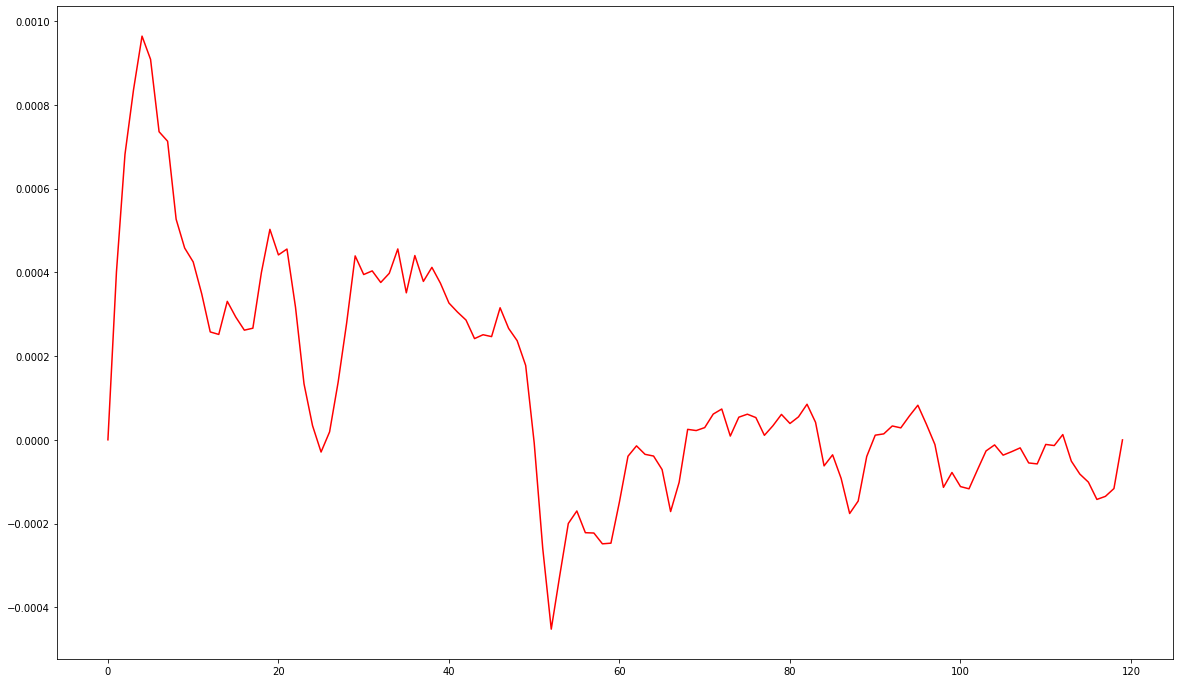

In [72]:
c_ny = solve_state("New York", smooth_weight=500, enddate="2021-12-01")

2020-01-01 00:00:00
2021-12-01 00:00:00
None
2021-12-01
made matrix system ((33771, 1), (33771, 120))
Solved matrix system
sum(c) is [0.01447491]
expected days is [7.81721499]


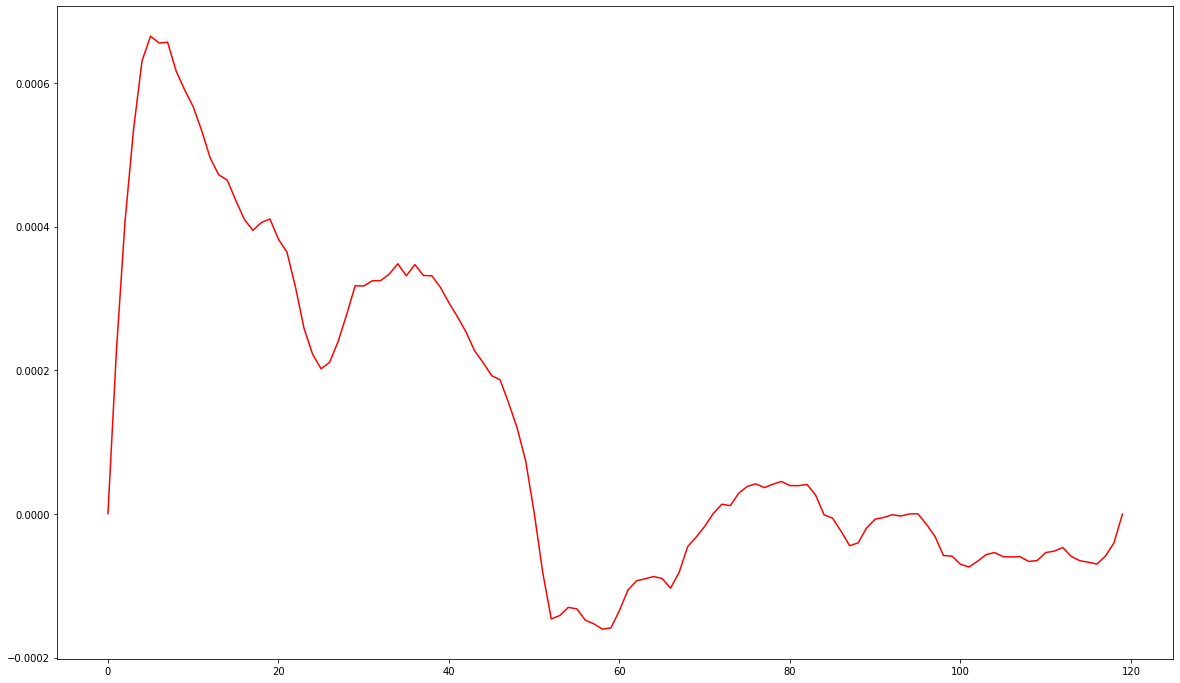

In [73]:
c_ny = solve_state("New York", smooth_weight=1200, enddate="2021-12-01")

2020-01-01 00:00:00
2022-03-17 00:00:00
None
None
made matrix system ((39493, 1), (39493, 120))
Solved matrix system
sum(c) is [0.0083526]
expected days is [39.05169103]


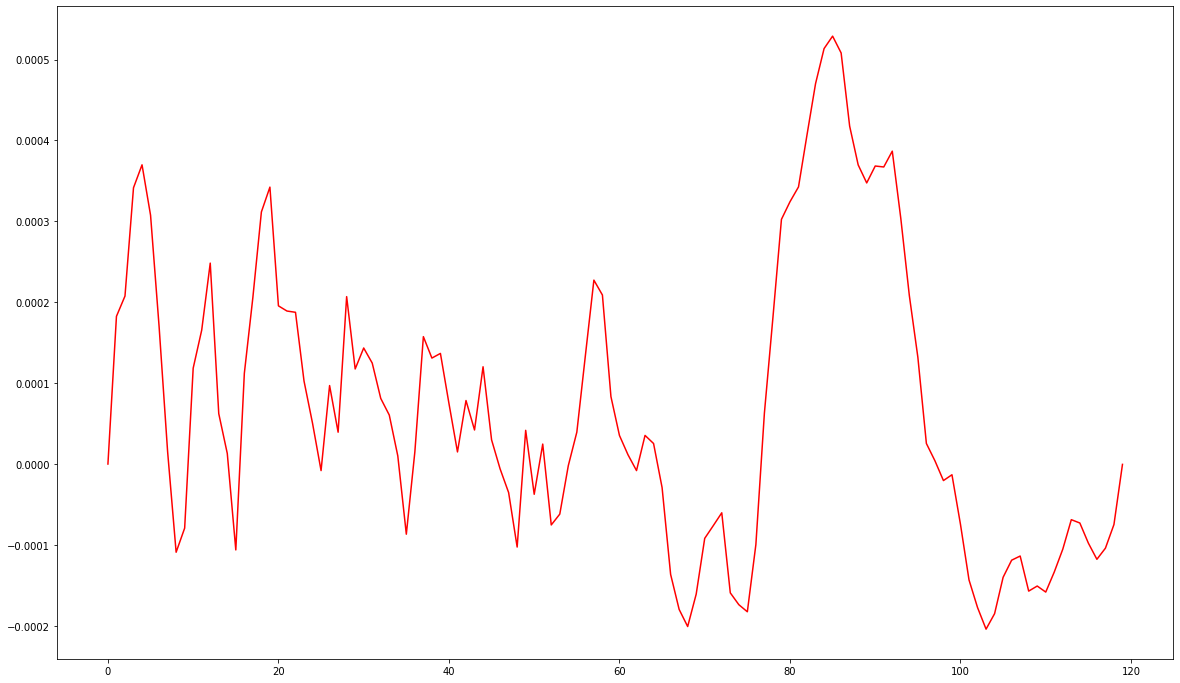

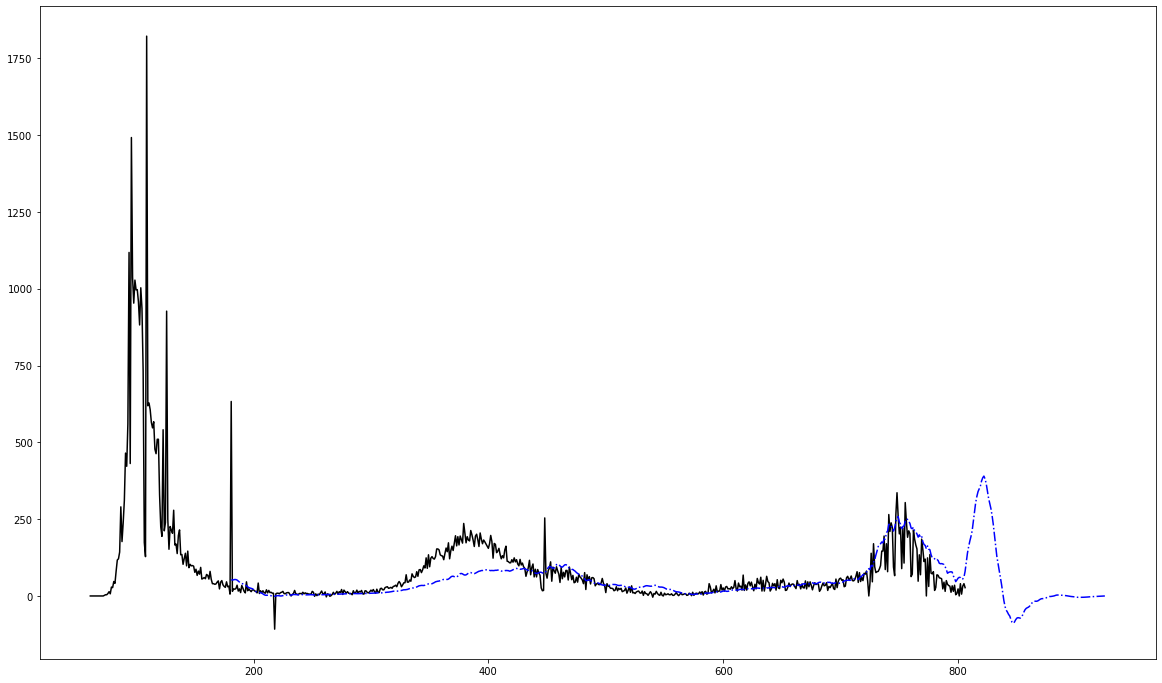

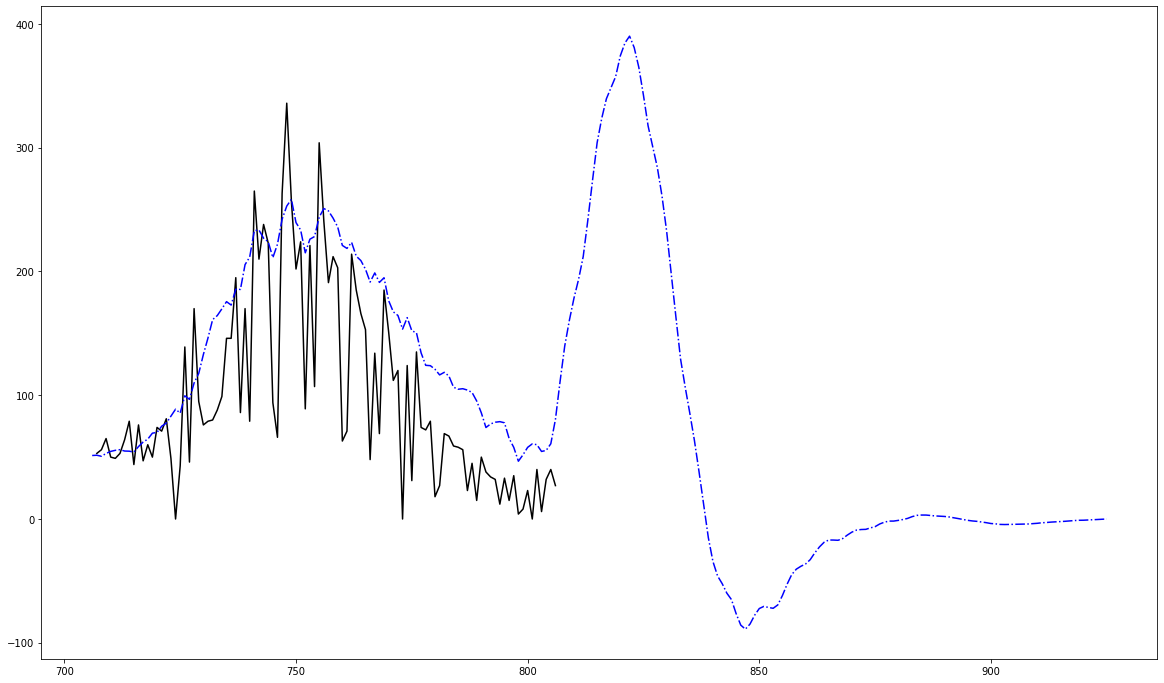

Today's date, 2022-03-18 is day number 807


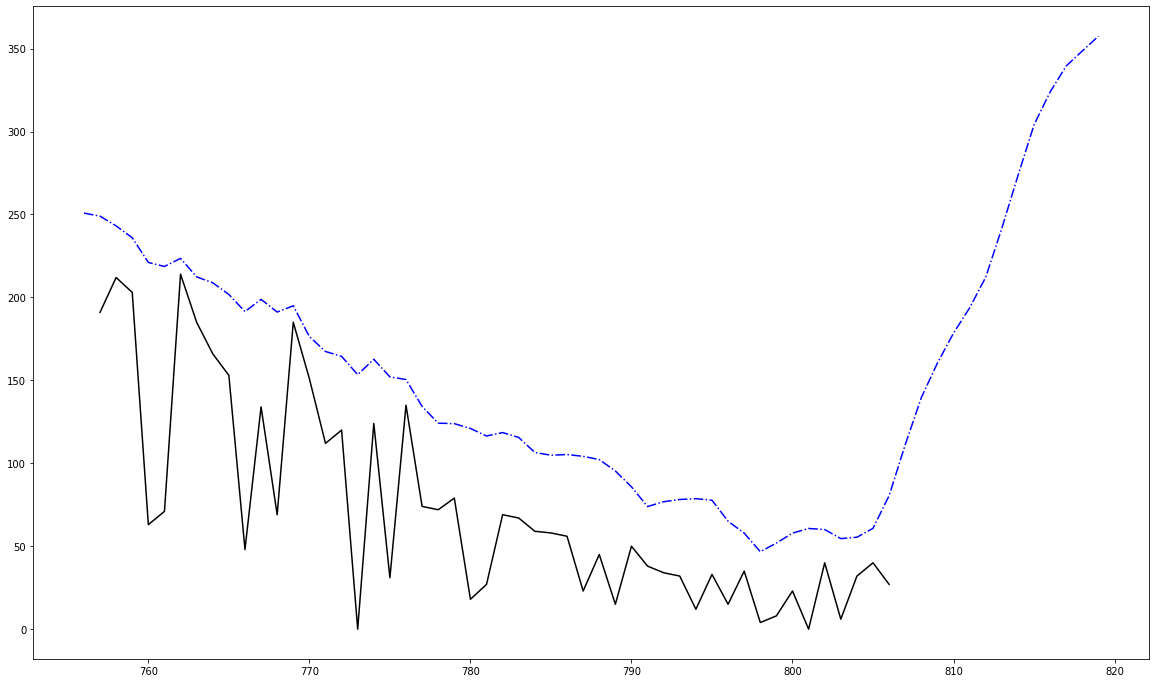

In [74]:
plot_predictions("New York", smooth_weight=1200)

holding out data after 2020-12-01
2020-01-01 00:00:00
2020-12-01 00:00:00
None
2020-12-01
made matrix system ((14076, 1), (14076, 120))
Solved matrix system
sum(c) is [0.03871459]
expected days is [8.94565696]


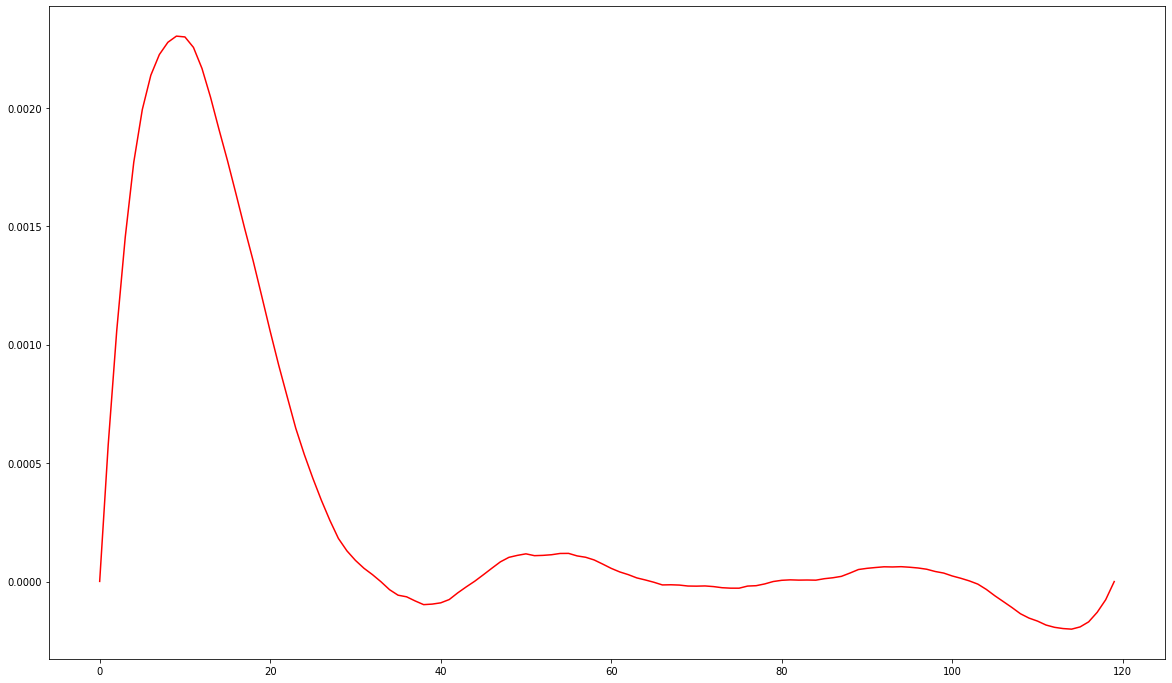

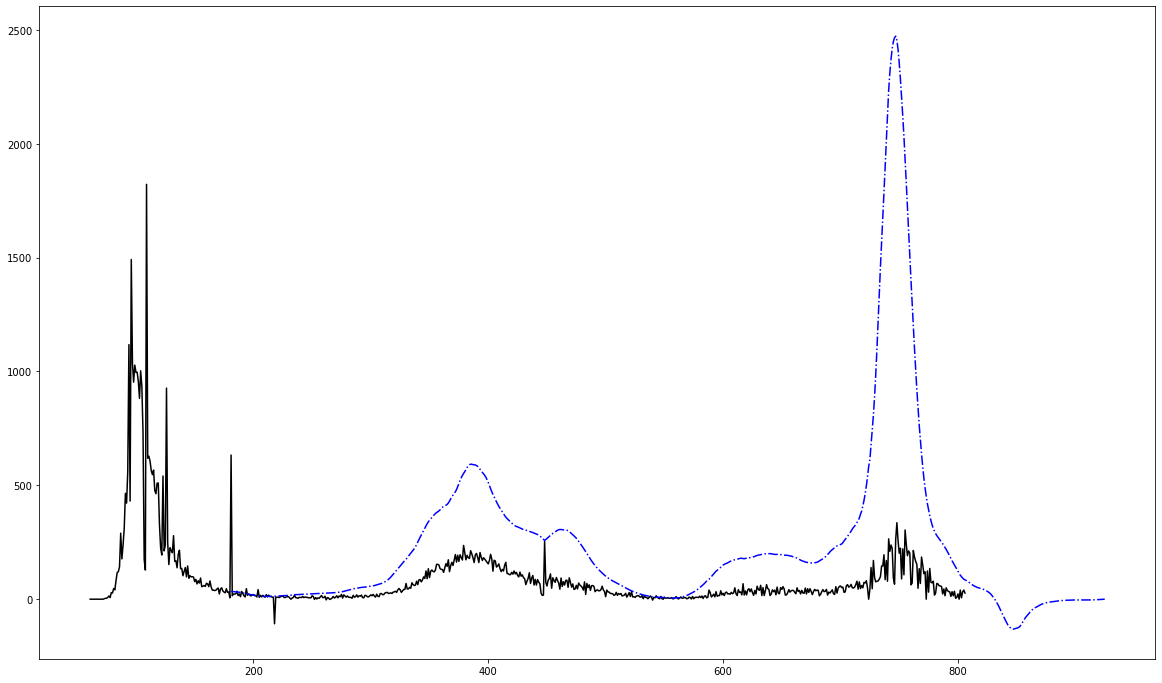

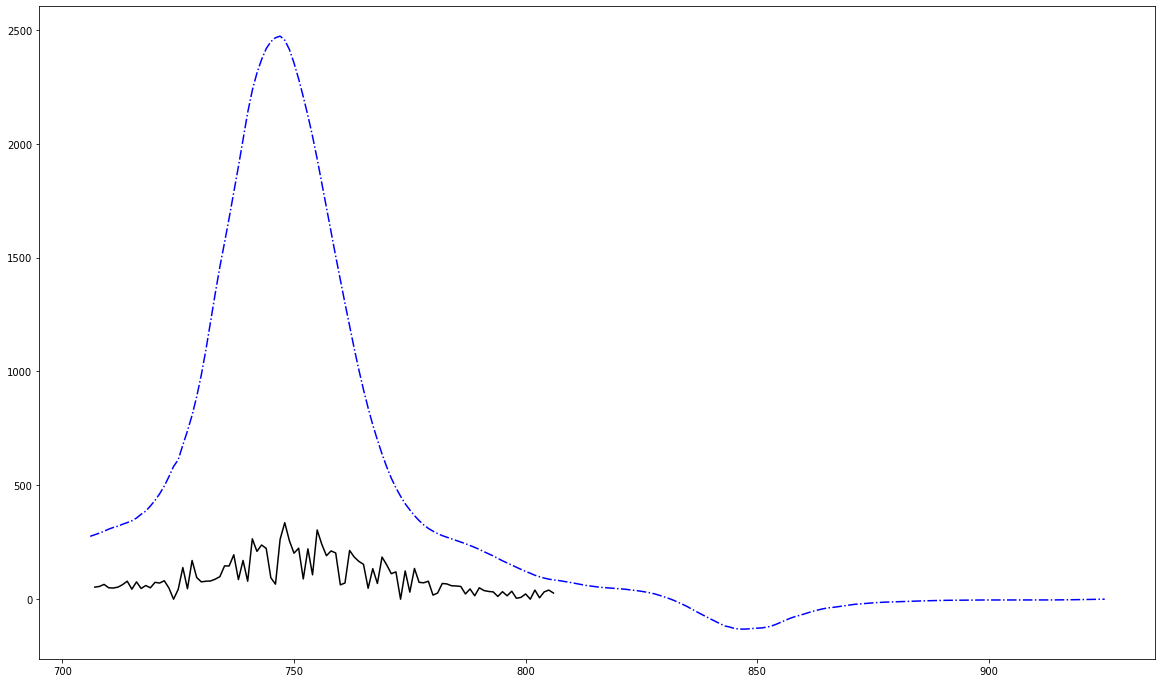

Today's date, 2022-03-18 is day number 807


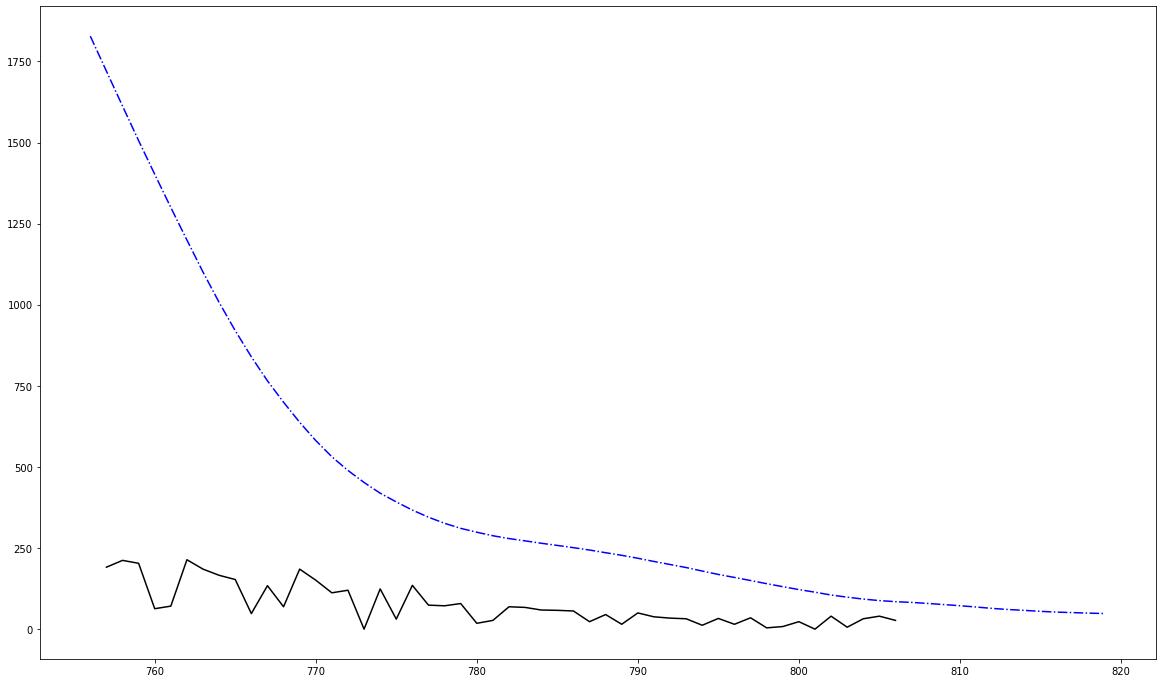

In [75]:
plot_predictions("New York", smooth_weight=1200, holdout_after="2020-12-01")

holding out data after 2021-09-01
2020-01-01 00:00:00
2021-09-01 00:00:00
None
2021-09-01
made matrix system ((28865, 1), (28865, 120))
Solved matrix system
sum(c) is [0.01497215]
expected days is [7.559744]


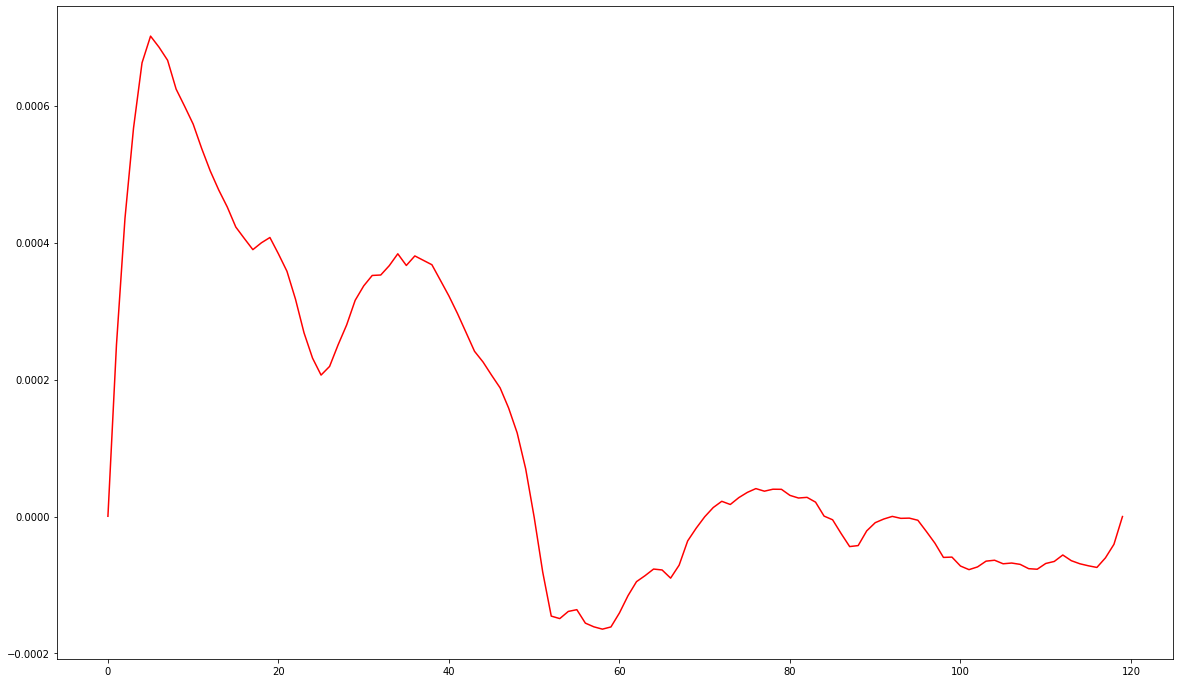

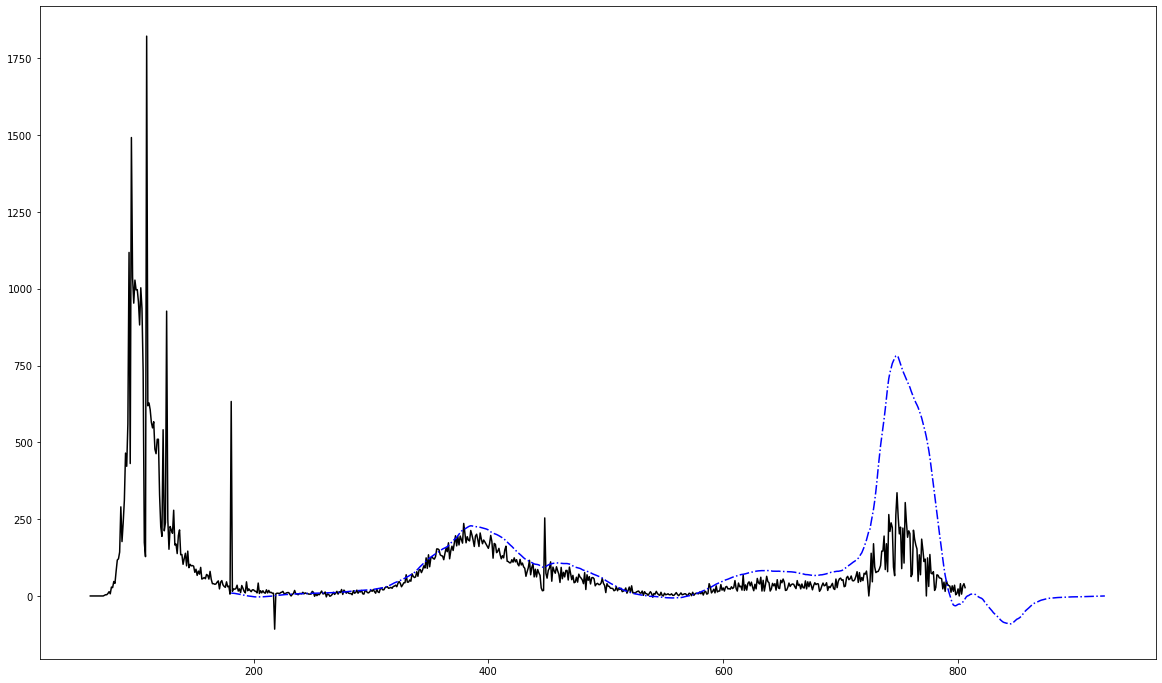

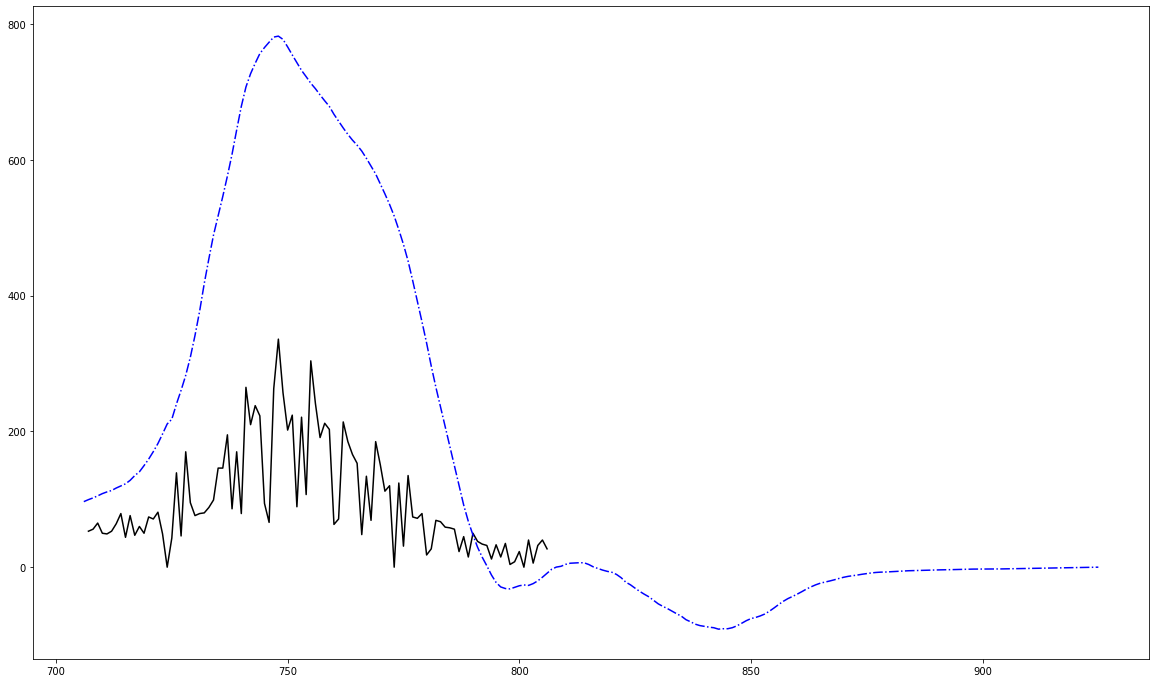

Today's date, 2022-03-18 is day number 807


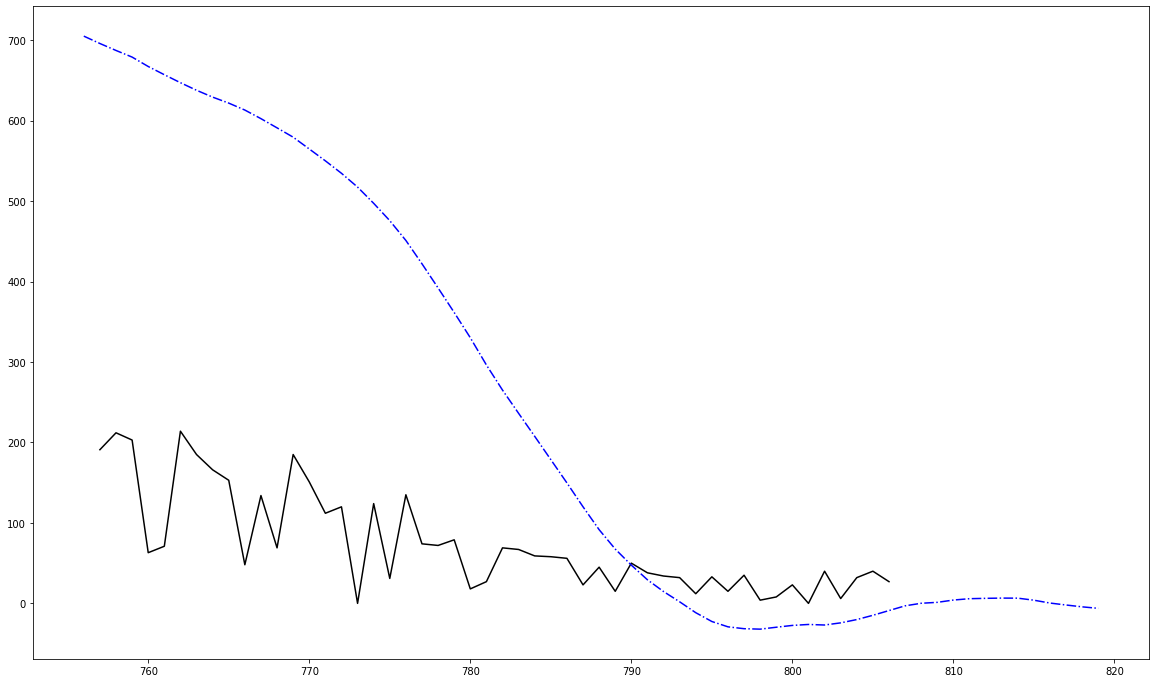

In [76]:
plot_predictions("New York", smooth_weight=1200, holdout_after="2021-09-01")

2020-01-01 00:00:00
2022-03-17 00:00:00
2021-05-01
None
made matrix system ((17443, 1), (17443, 120))
Solved matrix system
sum(c) is [0.00563118]
expected days is [49.92109999]


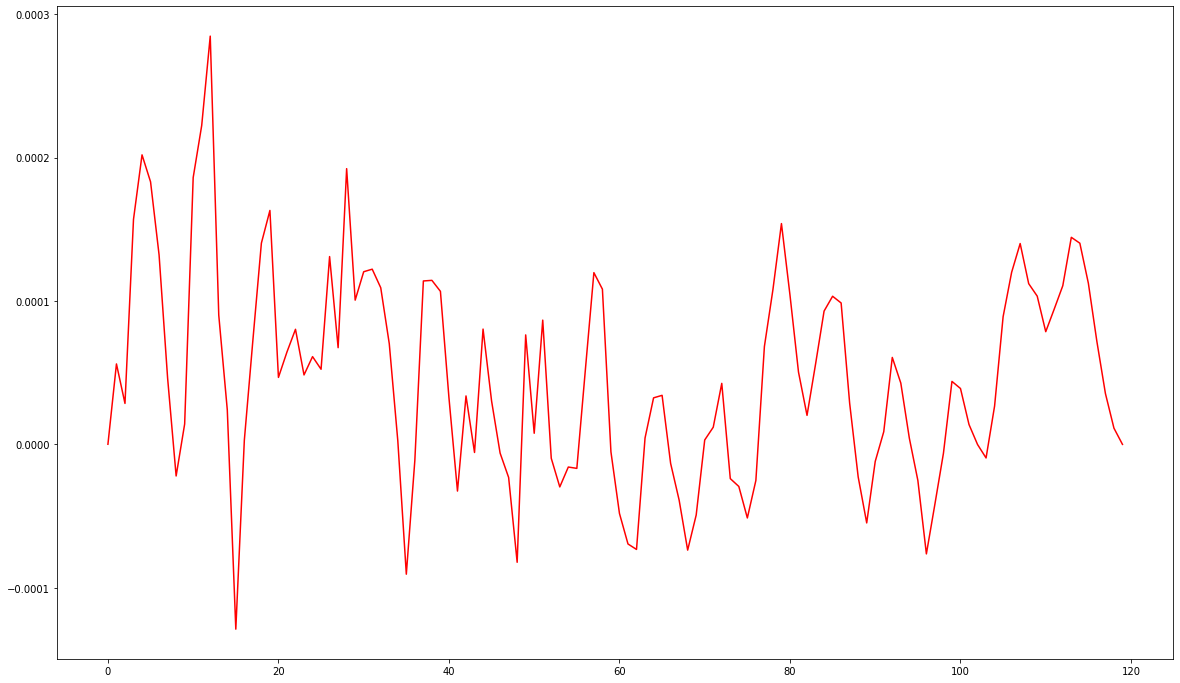

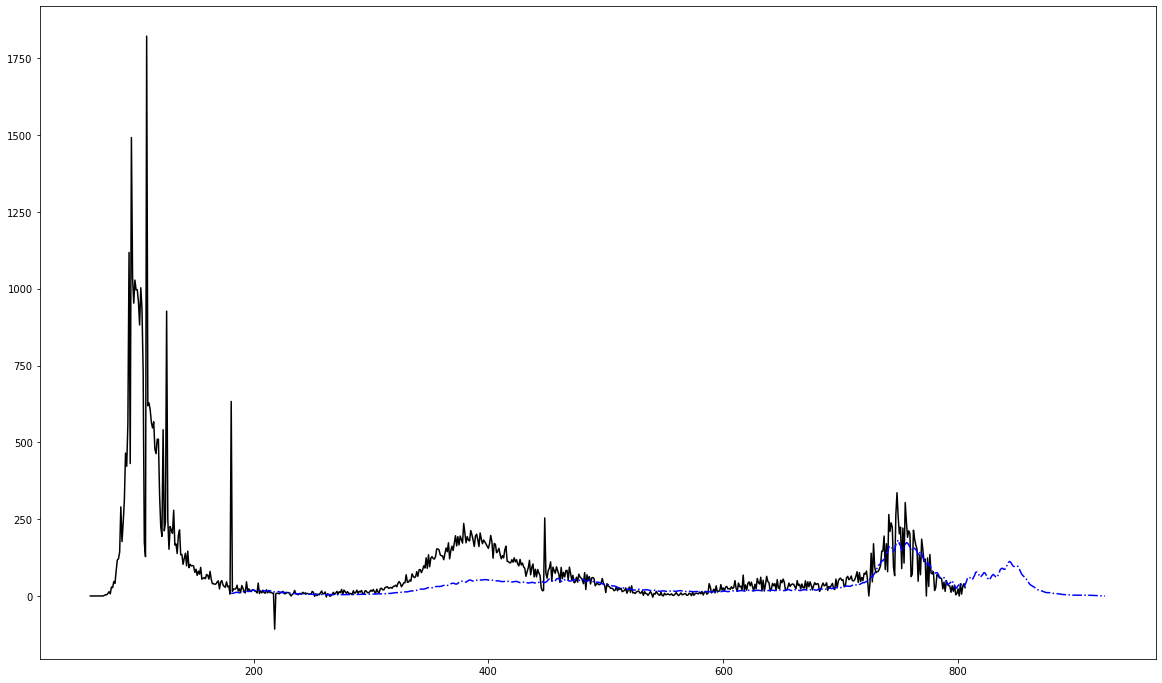

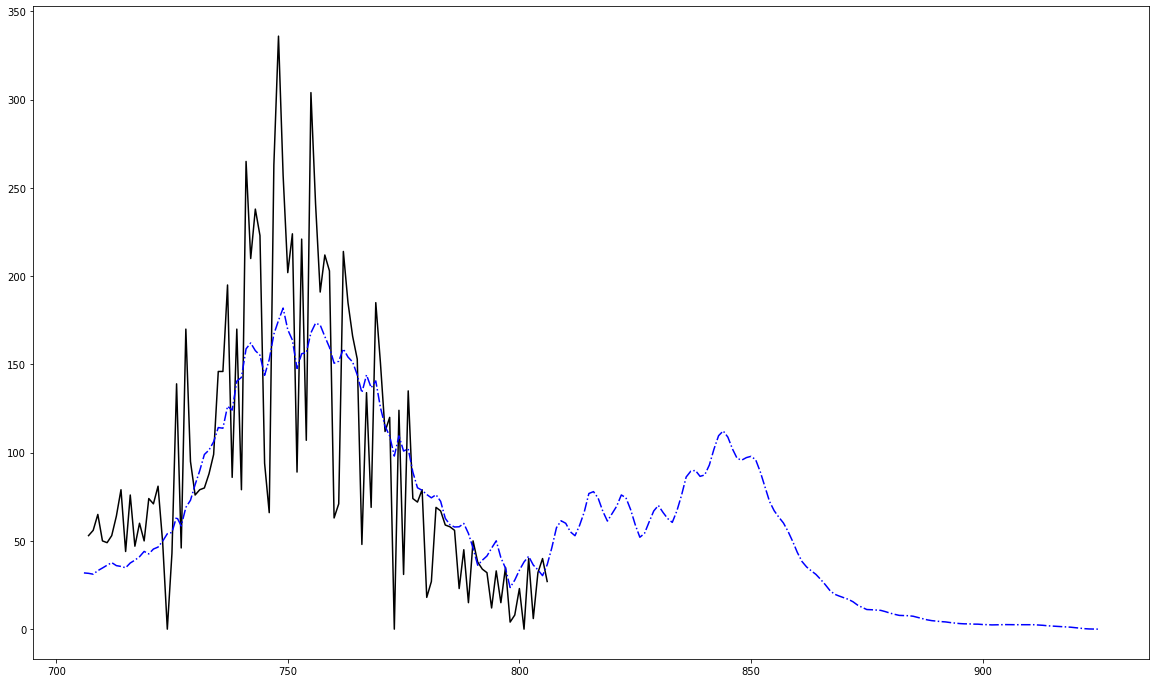

Today's date, 2022-03-18 is day number 807


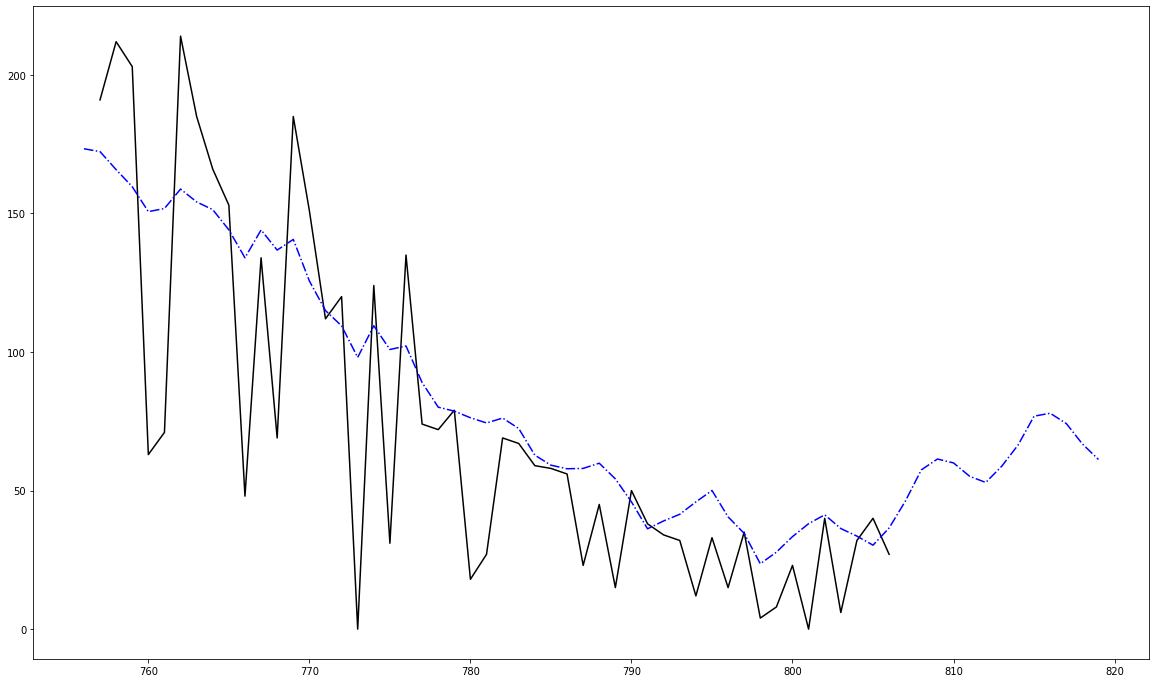

In [77]:
plot_predictions("New York", smooth_weight=1200, holdout_before="2021-05-01")

holding out data after 2021-11-01
2020-01-01 00:00:00
2021-11-01 00:00:00
2021-05-01
2021-11-01
made matrix system ((10101, 1), (10101, 120))
Solved matrix system
sum(c) is [0.00830598]
expected days is [29.86053865]


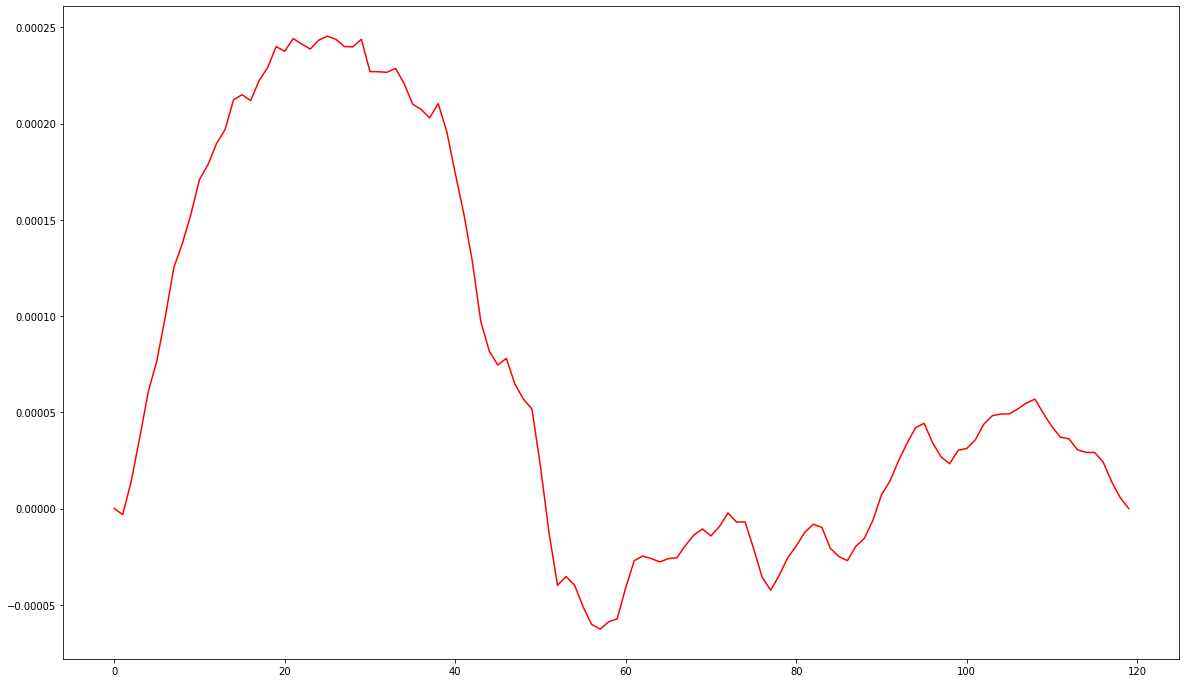

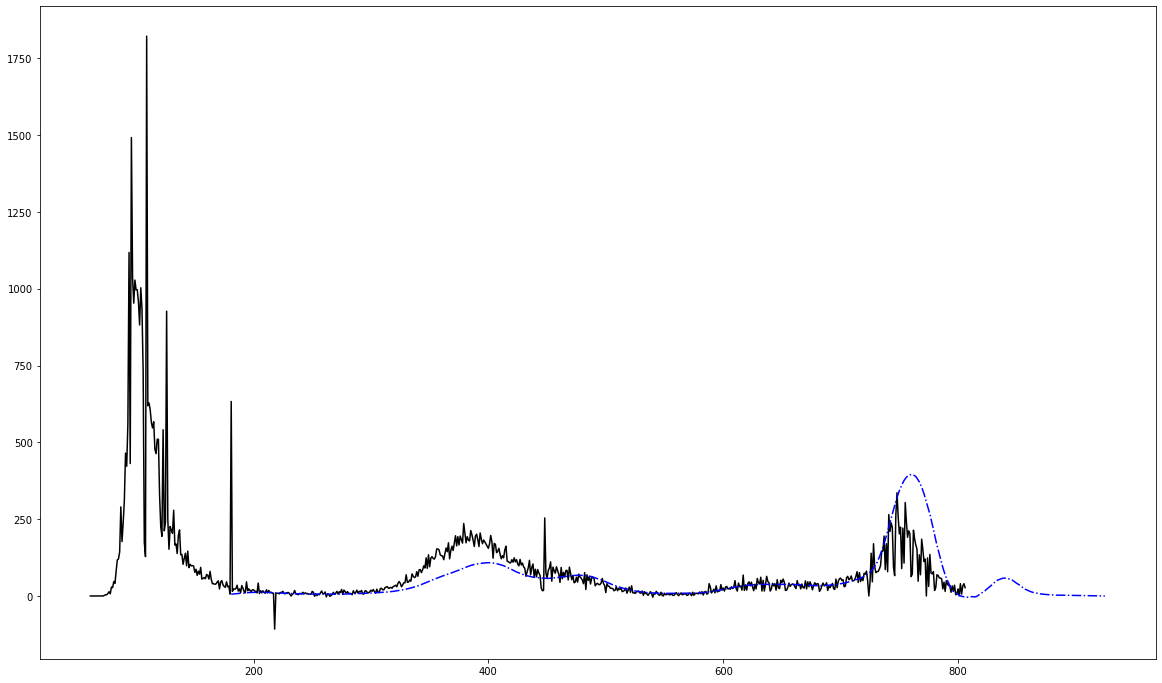

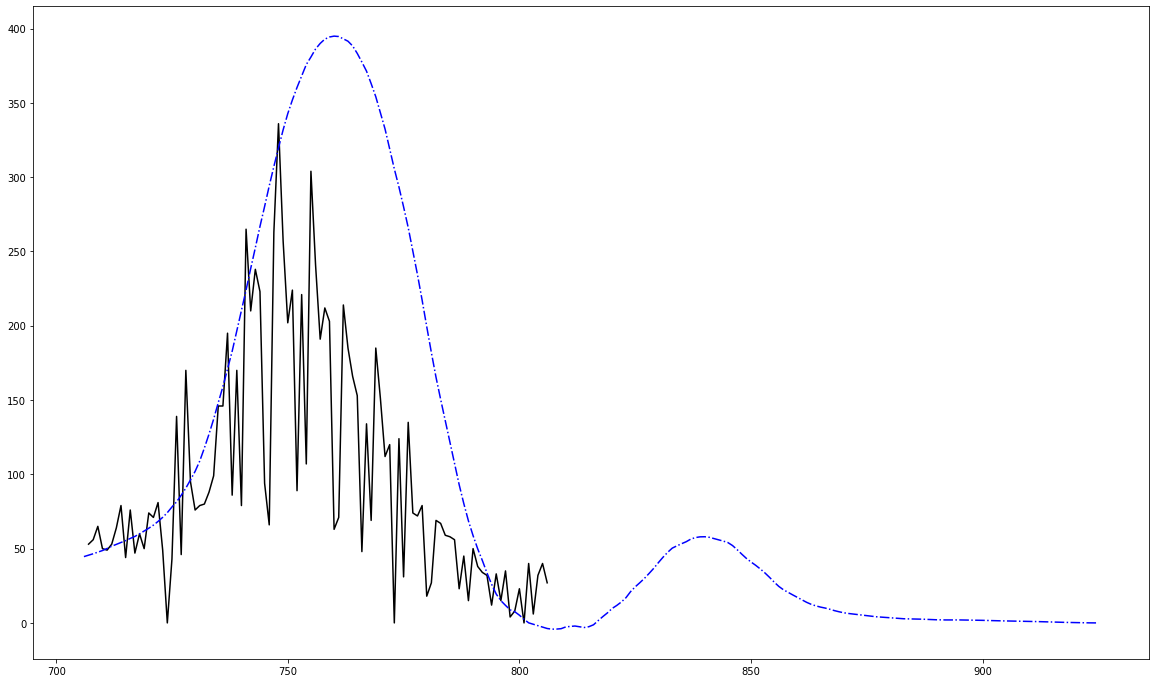

Today's date, 2022-03-18 is day number 807


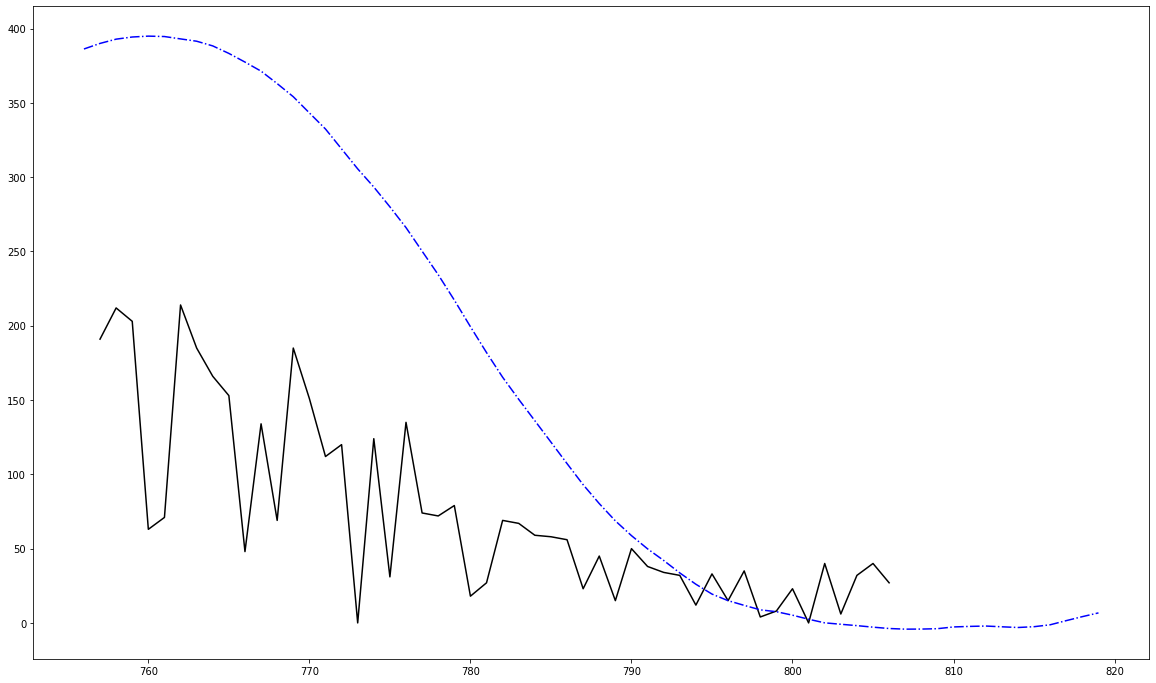

In [78]:
plot_predictions("New York", smooth_weight=1200, holdout_before="2021-05-01", holdout_after="2021-11-01")

2020-01-01 00:00:00
2022-03-17 00:00:00
2021-11-01
None
made matrix system ((7517, 1), (7517, 120))
Solved matrix system
sum(c) is [0.00622431]
expected days is [54.90230588]


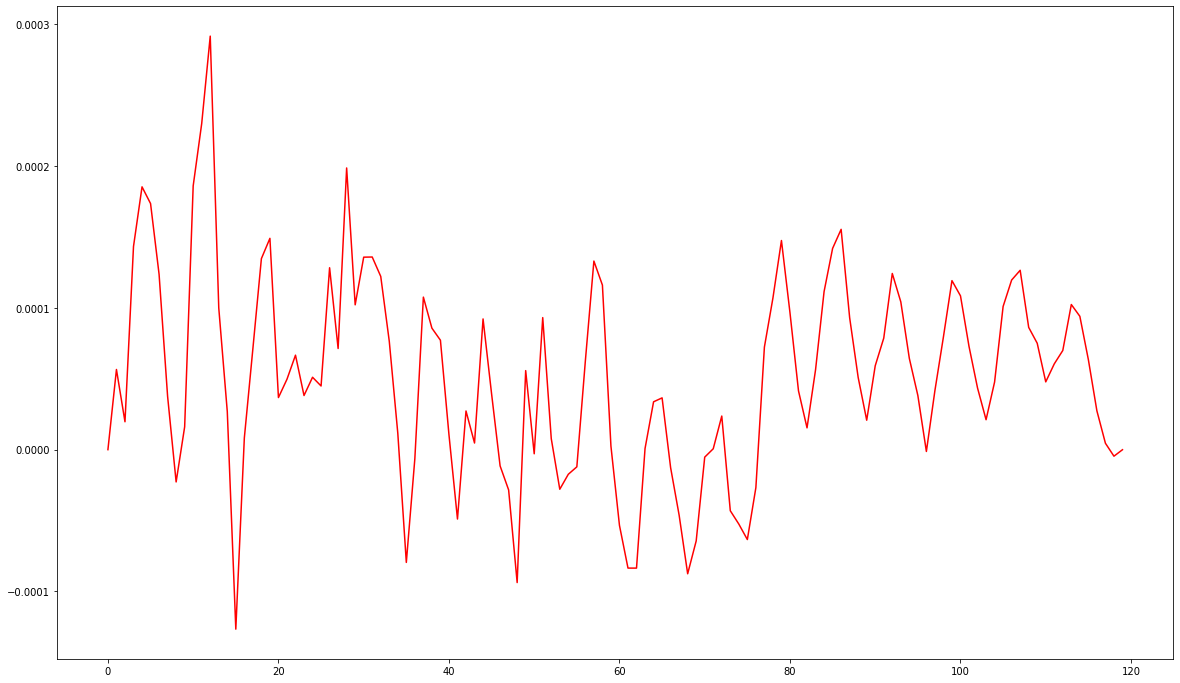

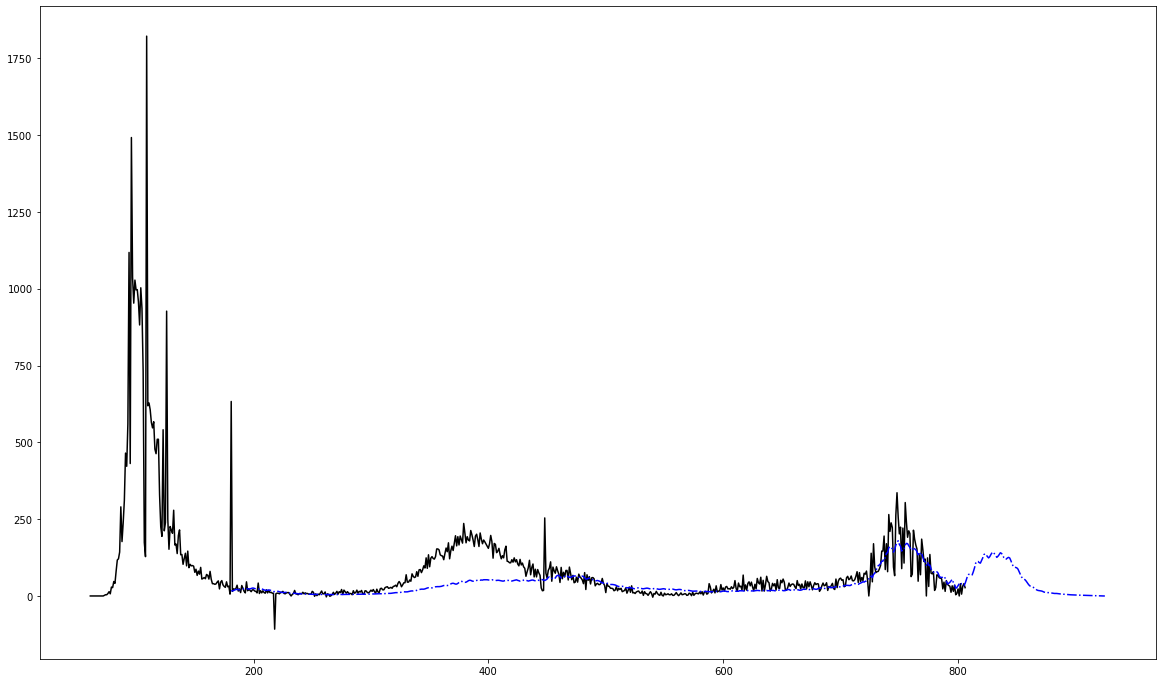

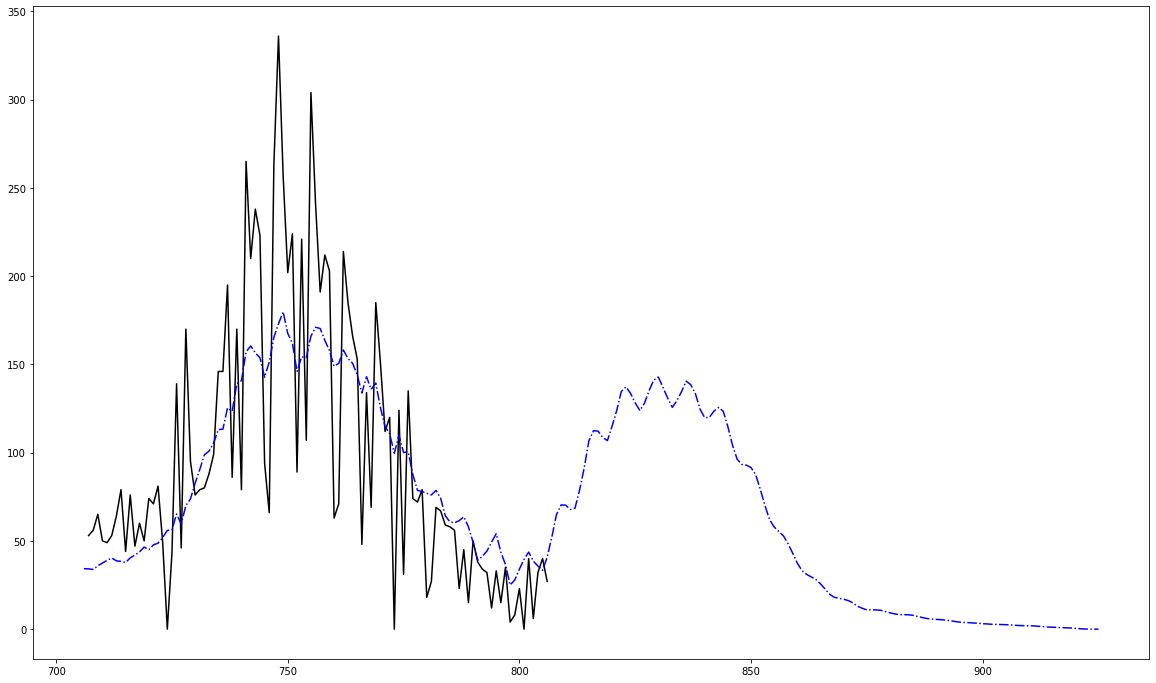

Today's date, 2022-03-18 is day number 807


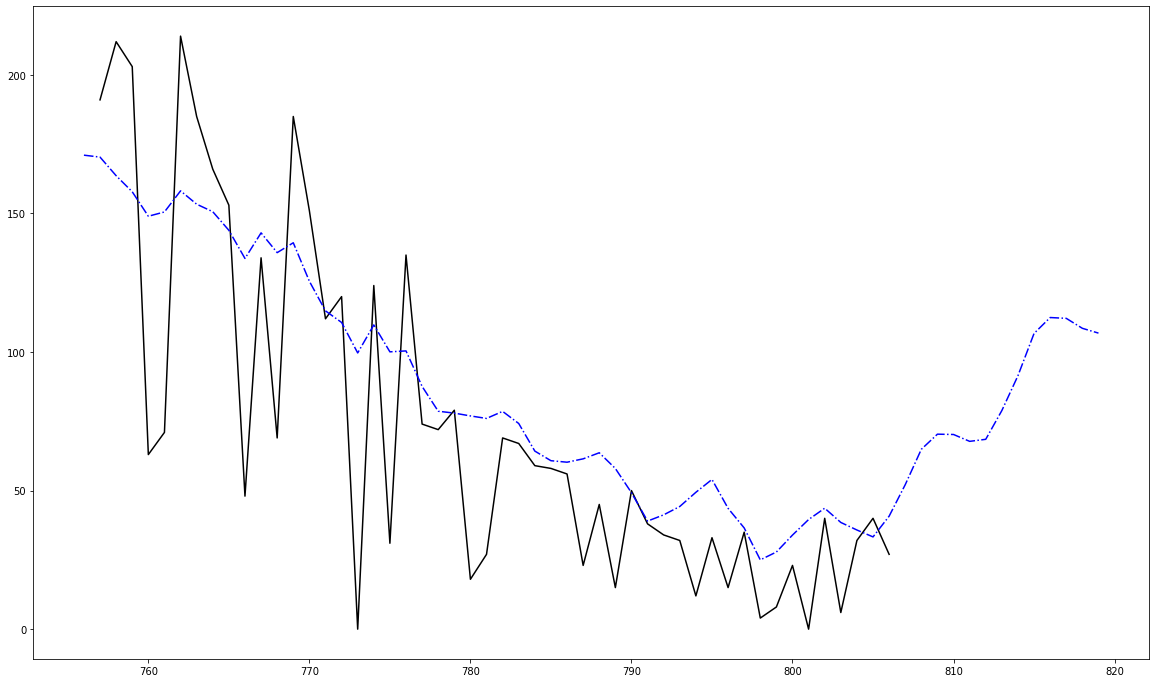

In [79]:
plot_predictions("New York", smooth_weight=1200, holdout_before="2021-11-01")

2020-01-01 00:00:00
2022-03-17 00:00:00
2021-11-01
None
made matrix system ((13106, 1), (13106, 120))
Solved matrix system
sum(c) is [0.00662538]
expected days is [58.51109935]


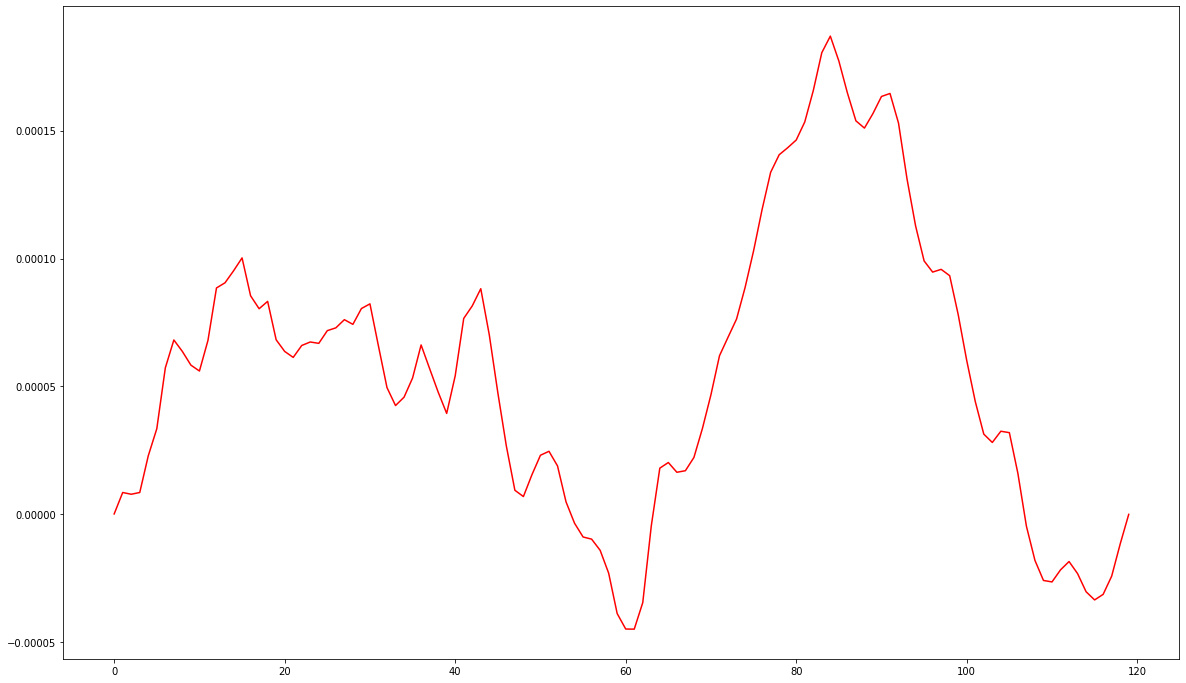

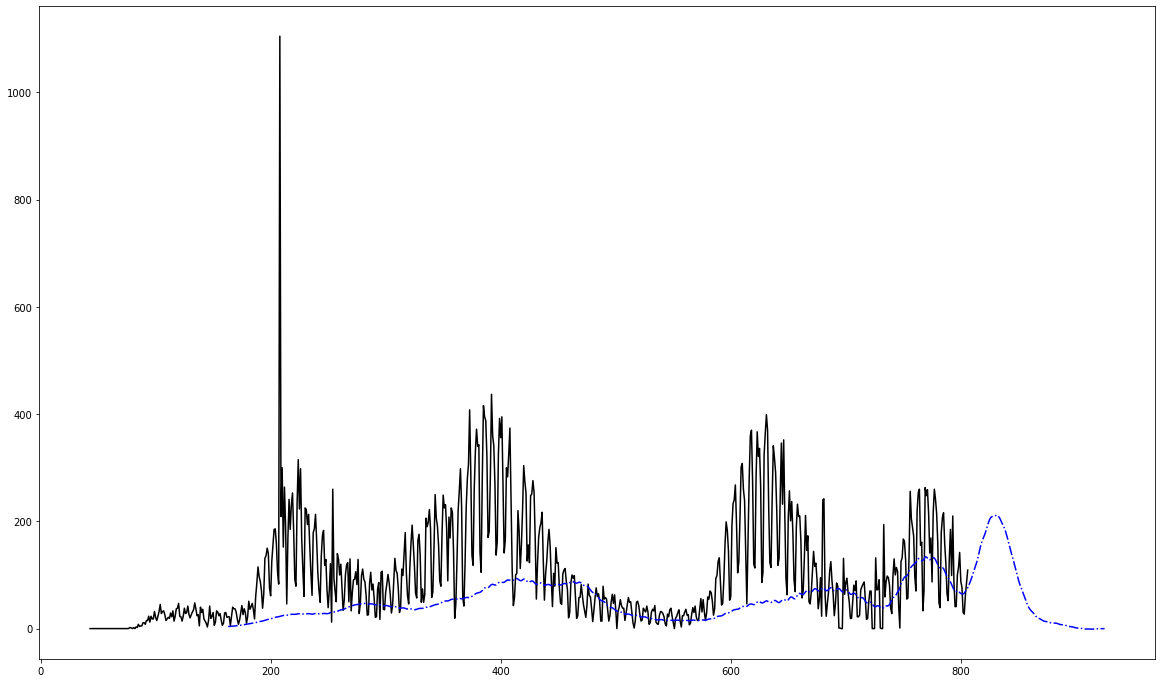

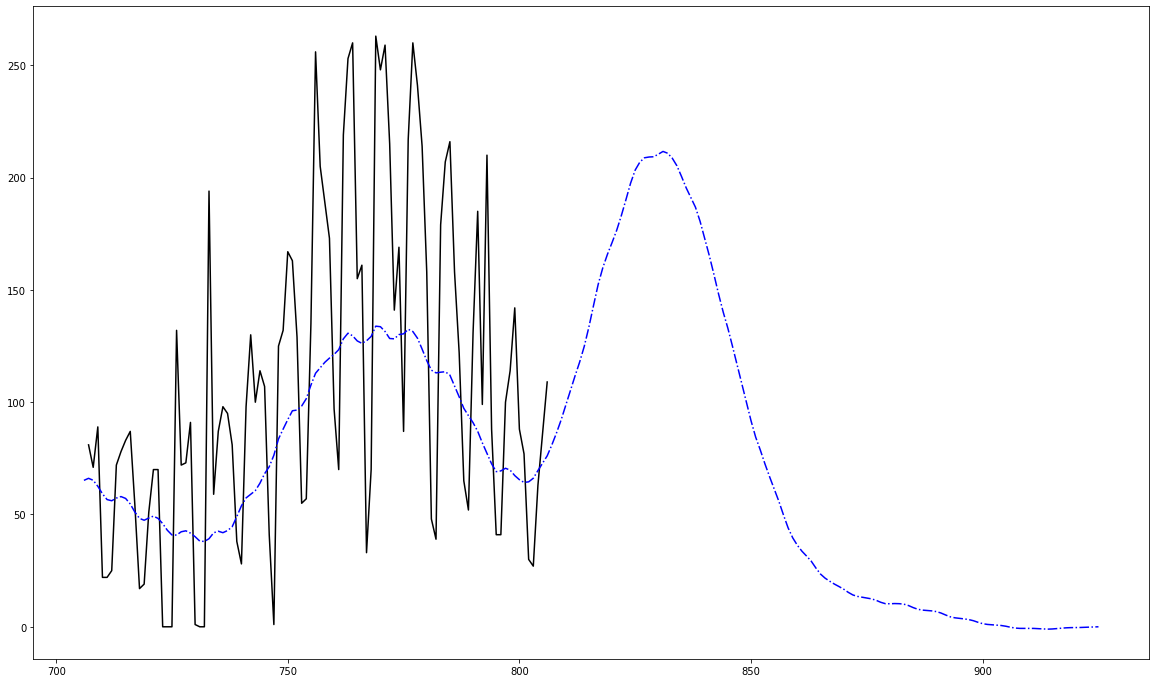

Today's date, 2022-03-18 is day number 807


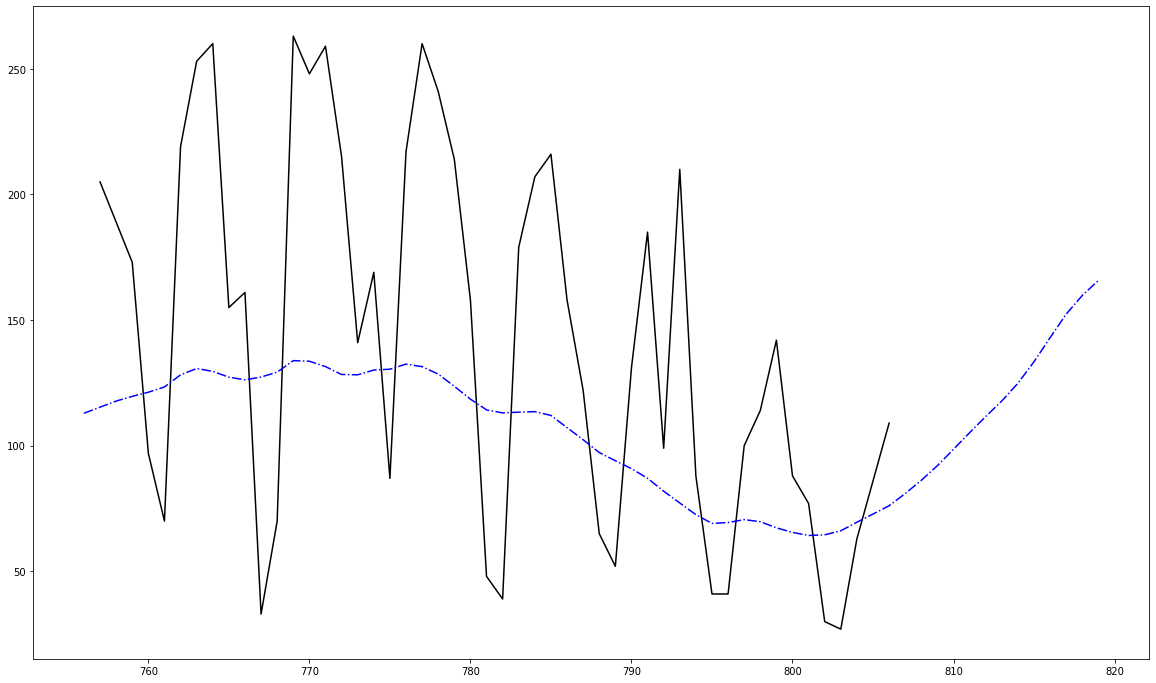

In [80]:
plot_predictions("Texas", smooth_weight=2400, holdout_before="2021-11-01")

2020-01-01 00:00:00
2022-03-17 00:00:00
2021-11-01
None
made matrix system ((5841, 1), (5841, 120))
Solved matrix system
sum(c) is [0.00894156]
expected days is [74.15207222]


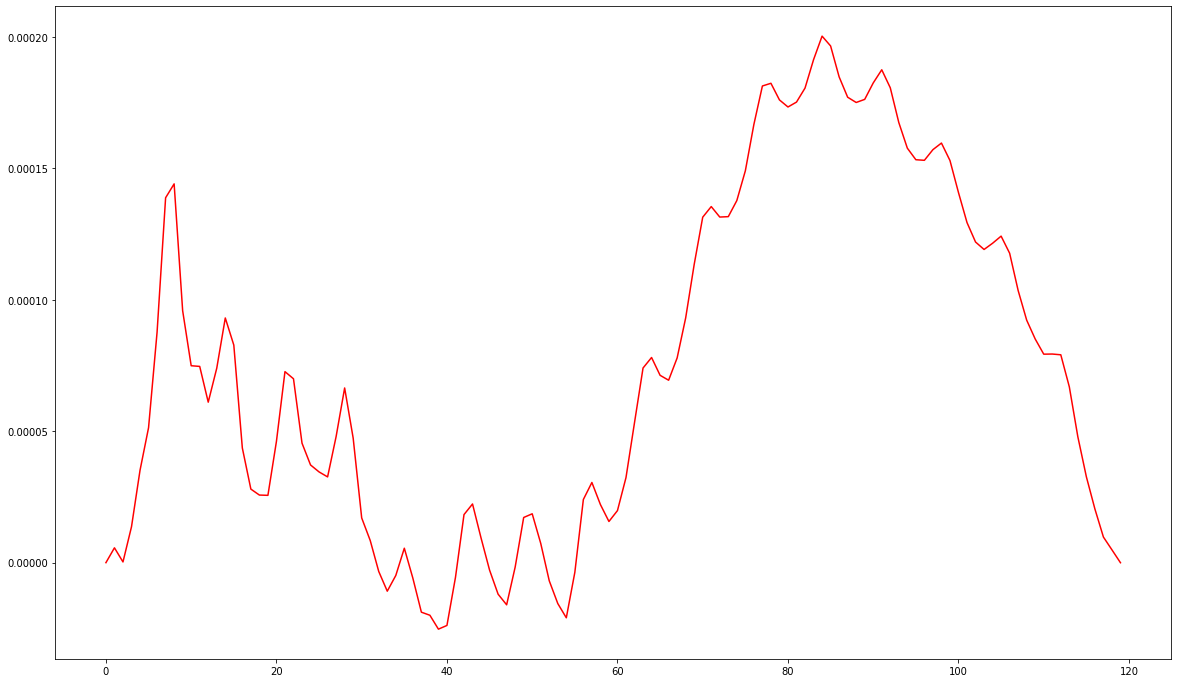

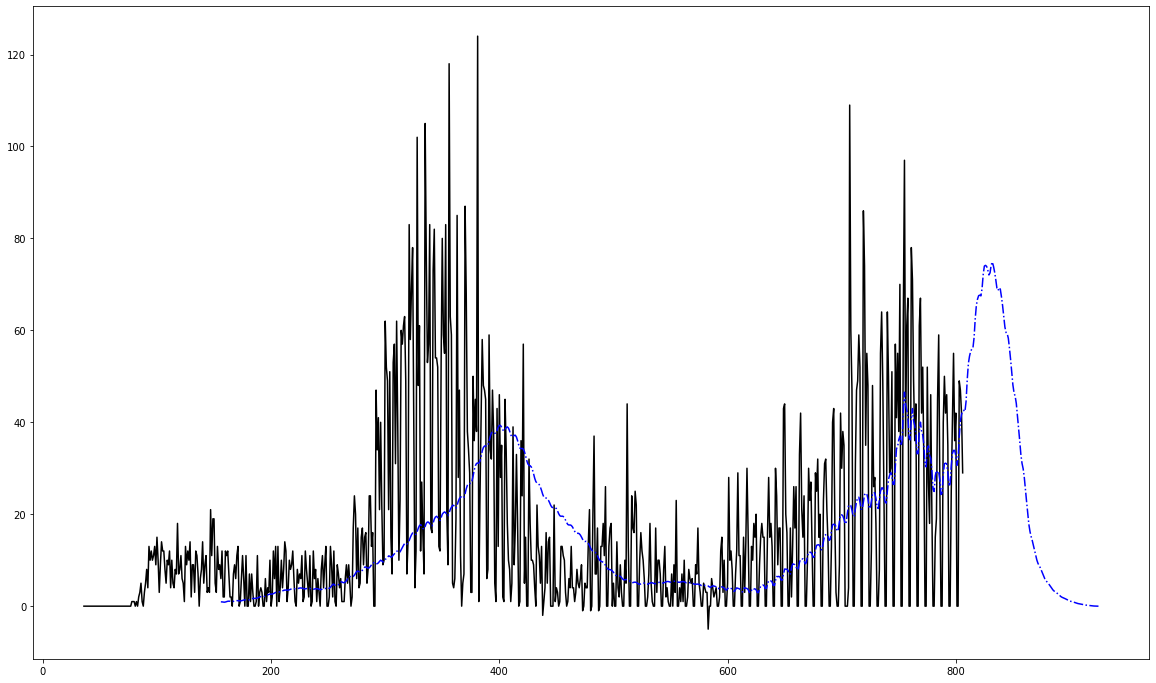

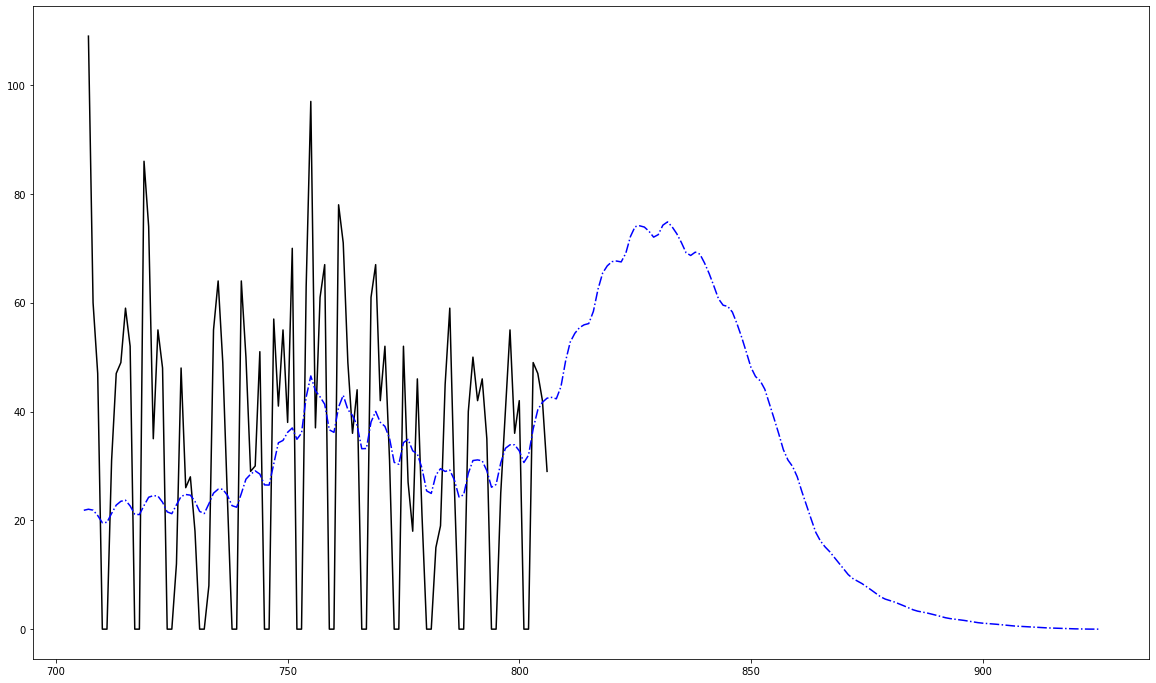

Today's date, 2022-03-18 is day number 807


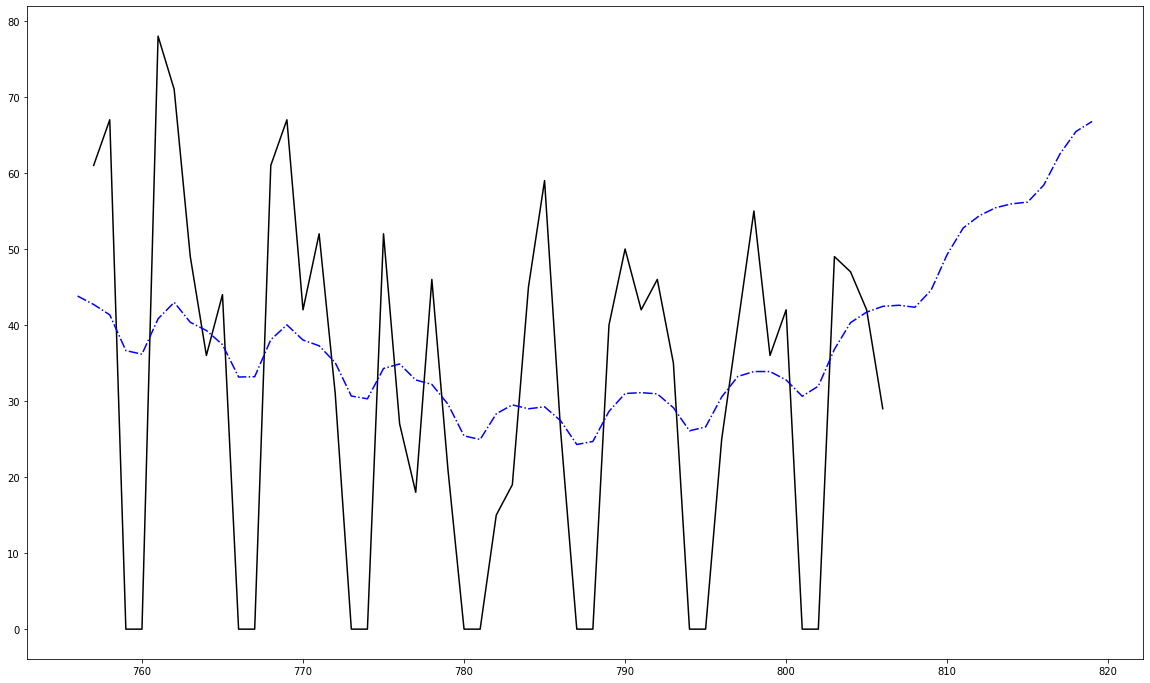

In [81]:
plot_predictions("Wisconsin", smooth_weight=1200, holdout_before="2021-11-01")

2020-01-01 00:00:00
2022-03-17 00:00:00
2021-11-01
None
made matrix system ((6794, 1), (6794, 120))
Solved matrix system
sum(c) is [0.0050838]
expected days is [56.60517342]


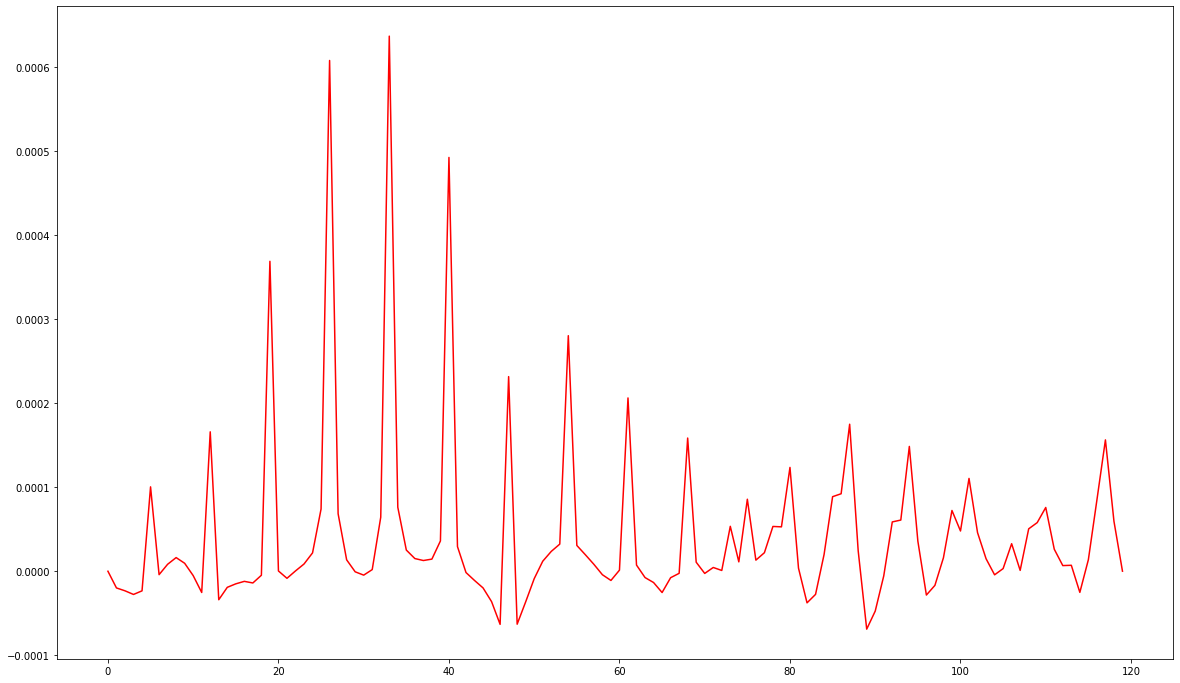

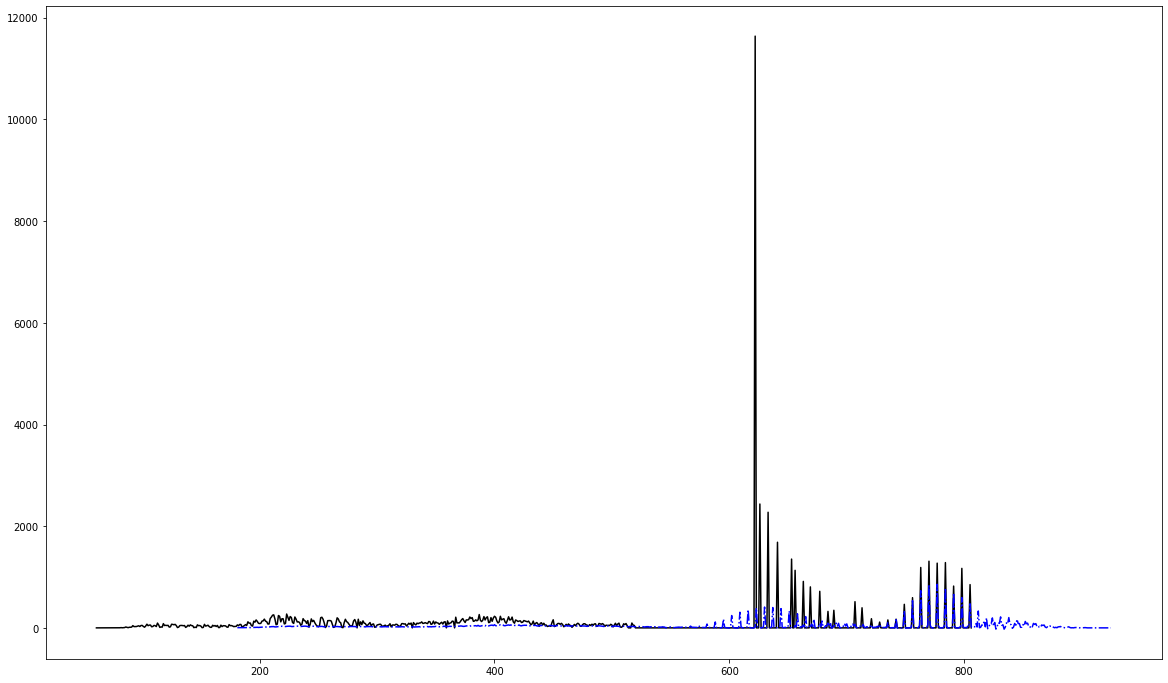

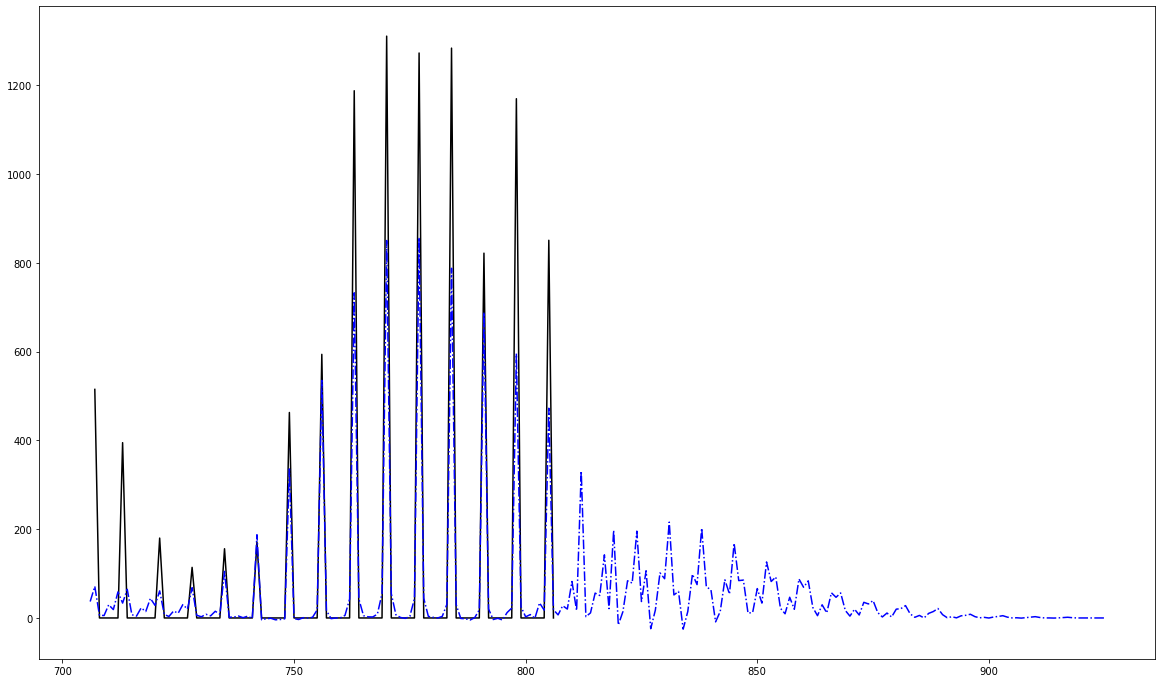

Today's date, 2022-03-18 is day number 807


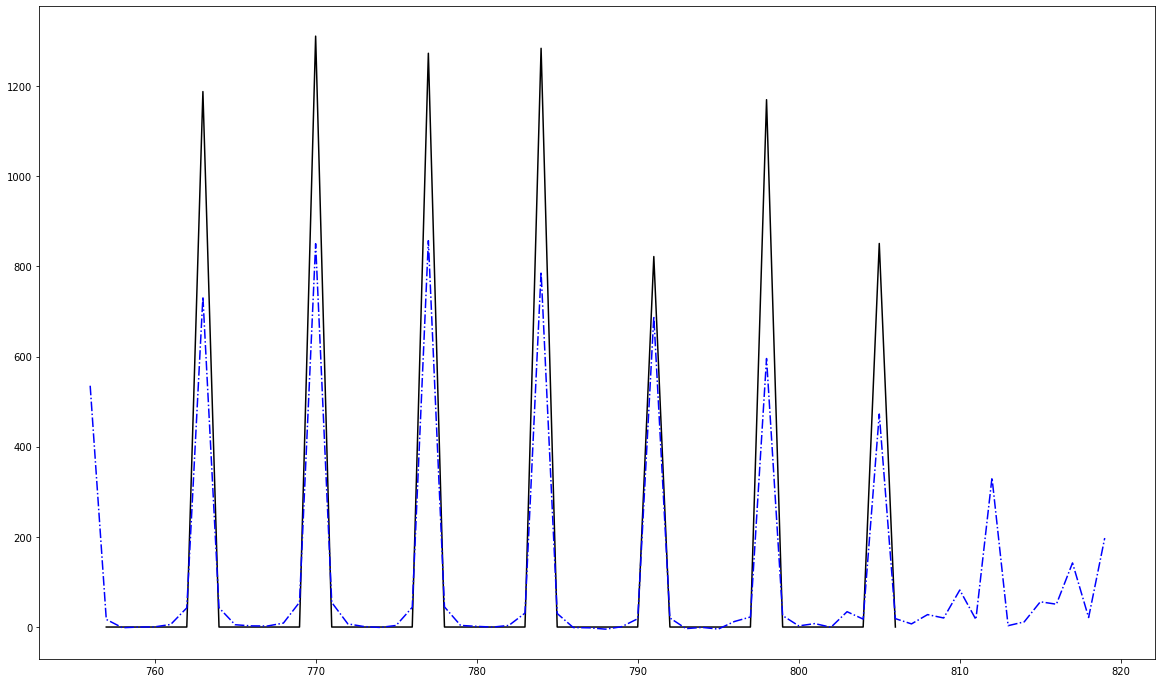

In [82]:
plot_predictions("Florida", smooth_weight=1200, holdout_before="2021-11-01")

holding out data after 2021-11-01
2020-01-01 00:00:00
2023-06-12 00:00:00
None
2021-11-01
made matrix system ((28831, 1), (28831, 120))
Solved matrix system
sum(c) is [0.01007335]
expected days is [25.66411079]


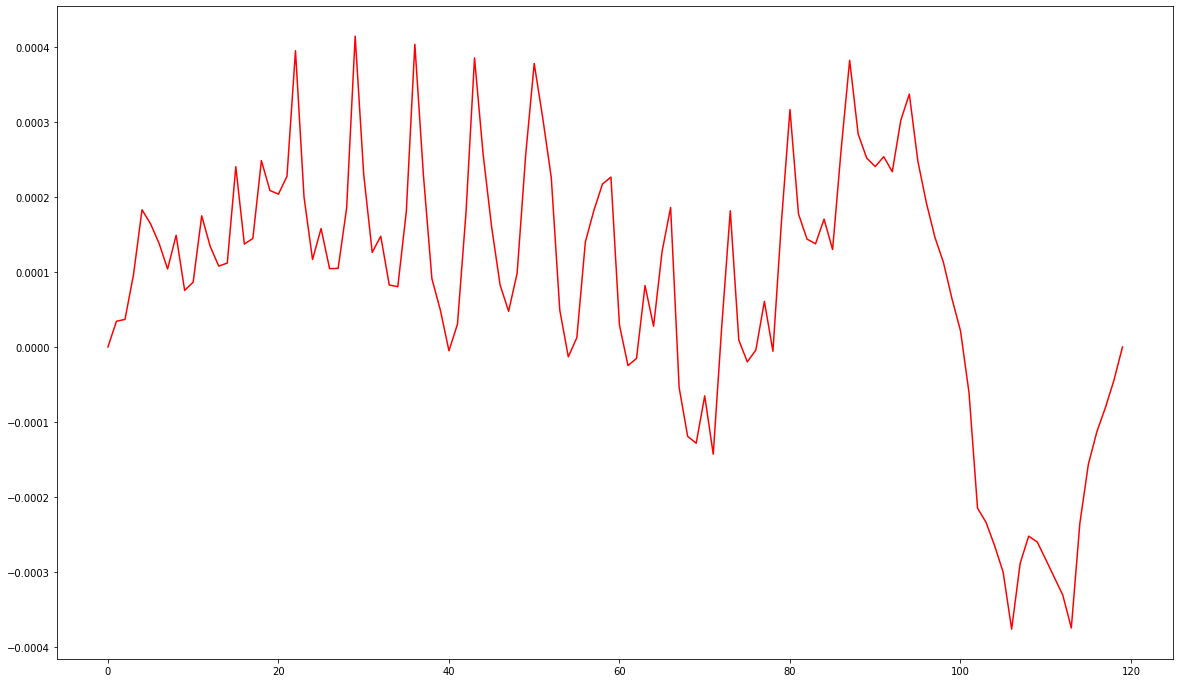

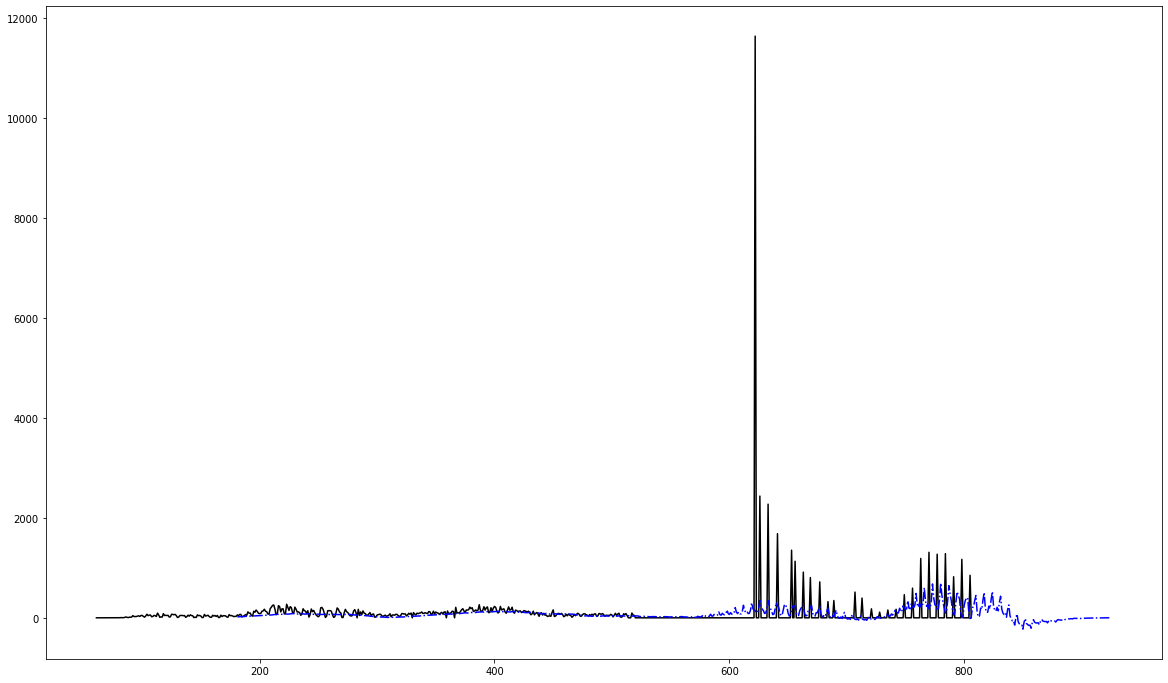

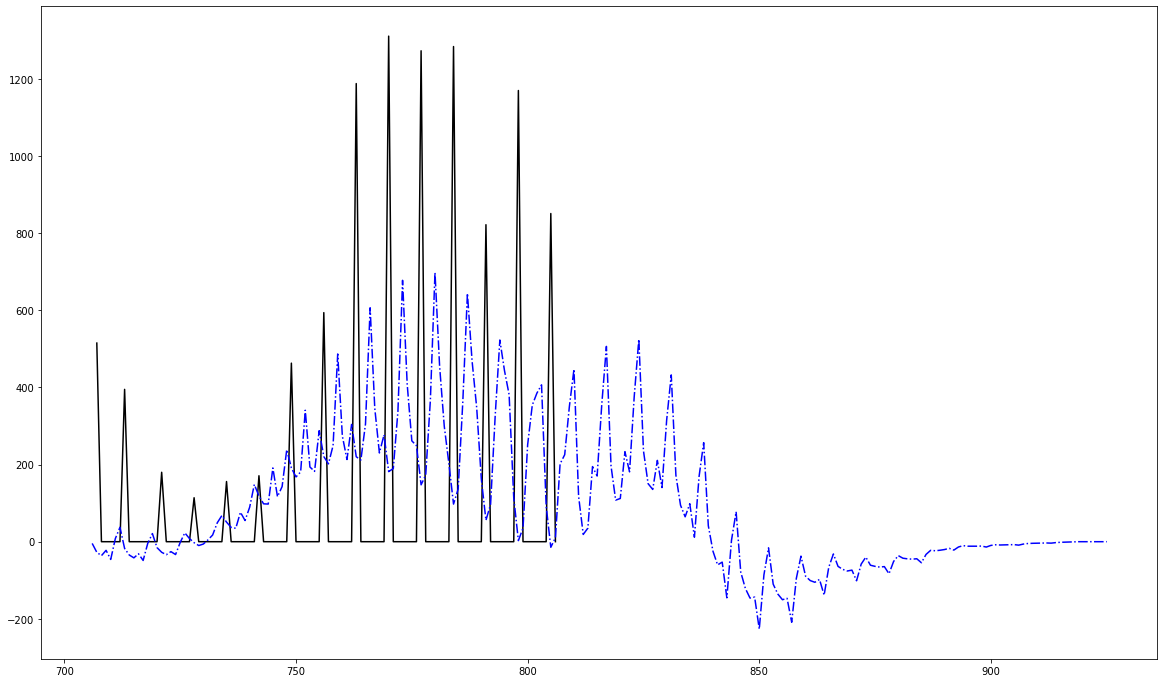

Today's date, 2022-03-18 is day number 807


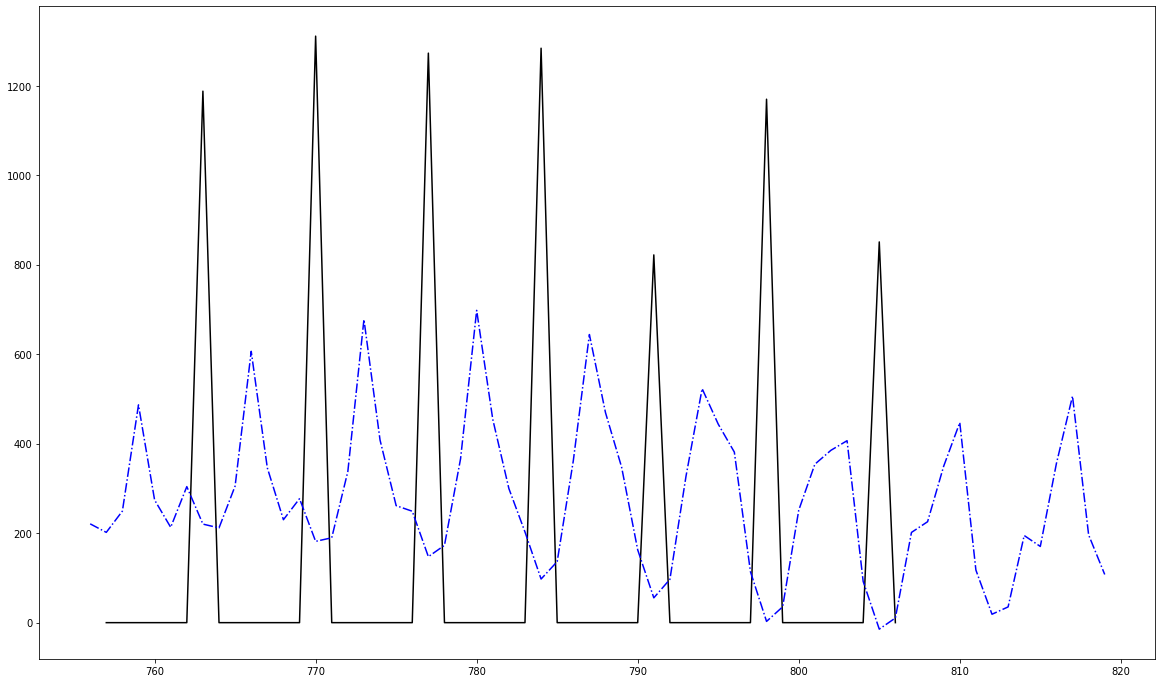

In [83]:
plot_predictions("Florida", smooth_weight=1200, holdout_after="2021-11-01")

2020-01-01 00:00:00
2022-03-17 00:00:00
2021-11-01
None
made matrix system ((1744, 1), (1744, 120))
Solved matrix system
sum(c) is [0.01108883]
expected days is [71.14725175]


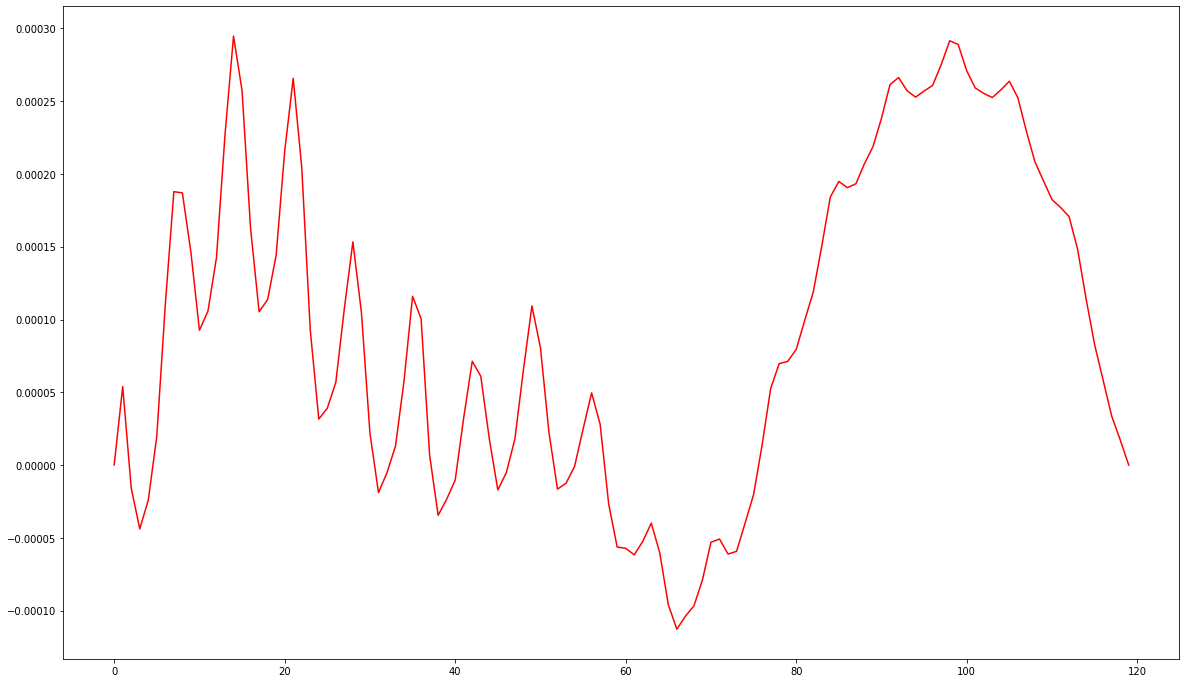

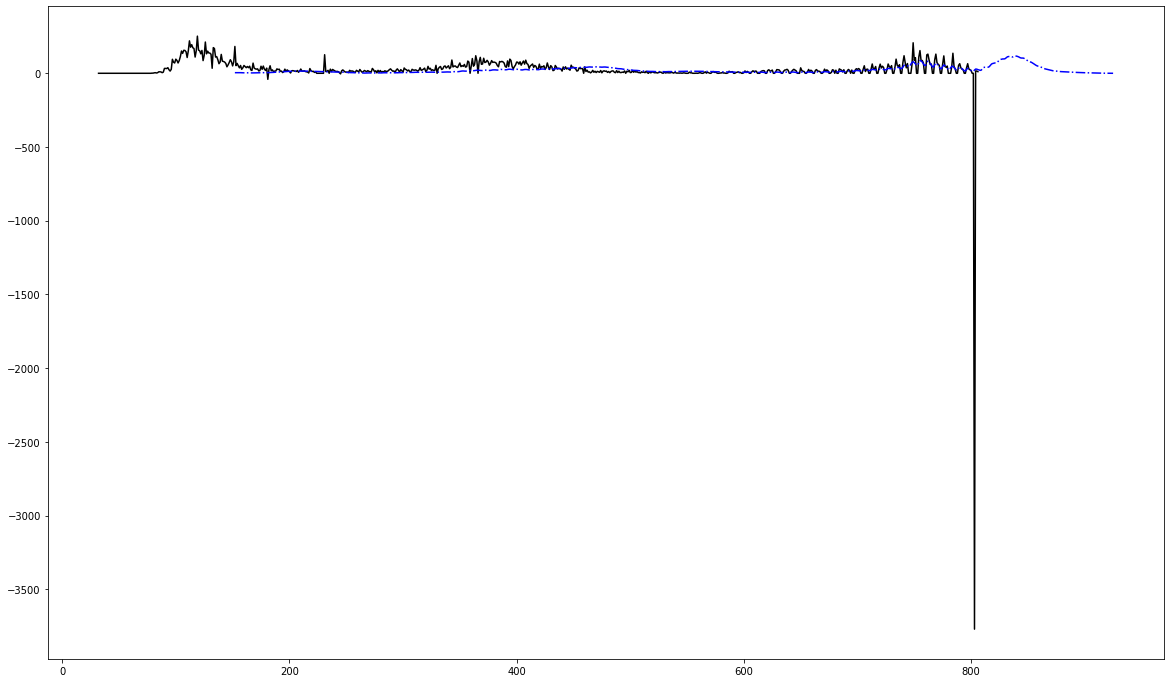

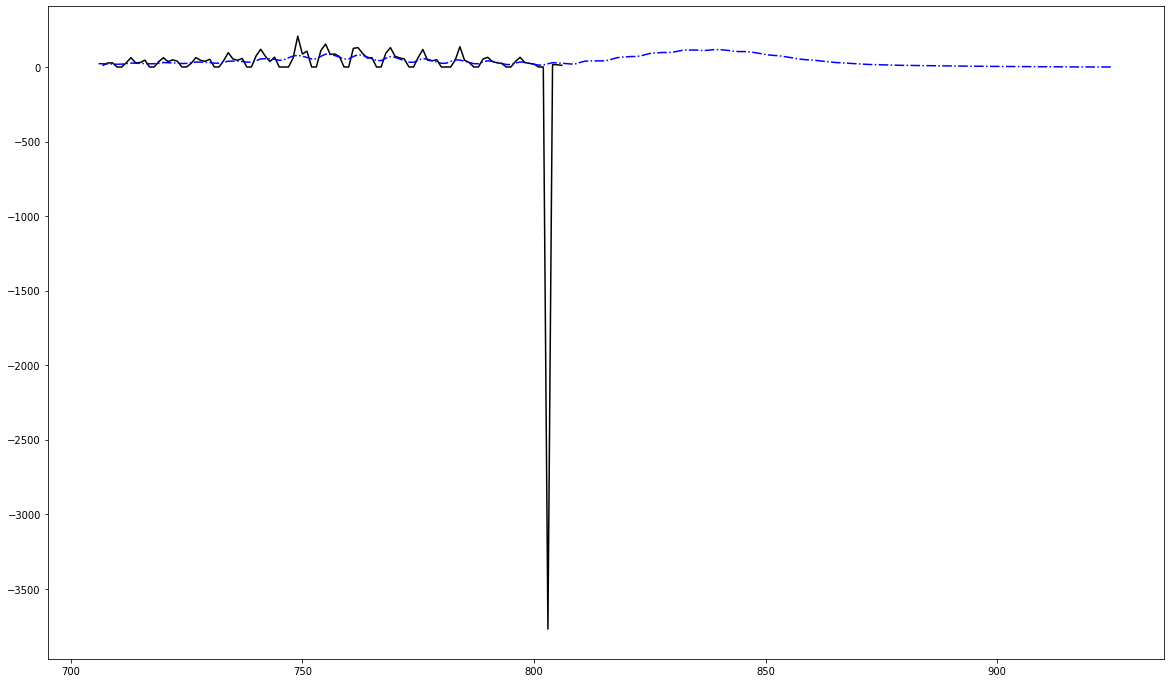

Today's date, 2022-03-18 is day number 807


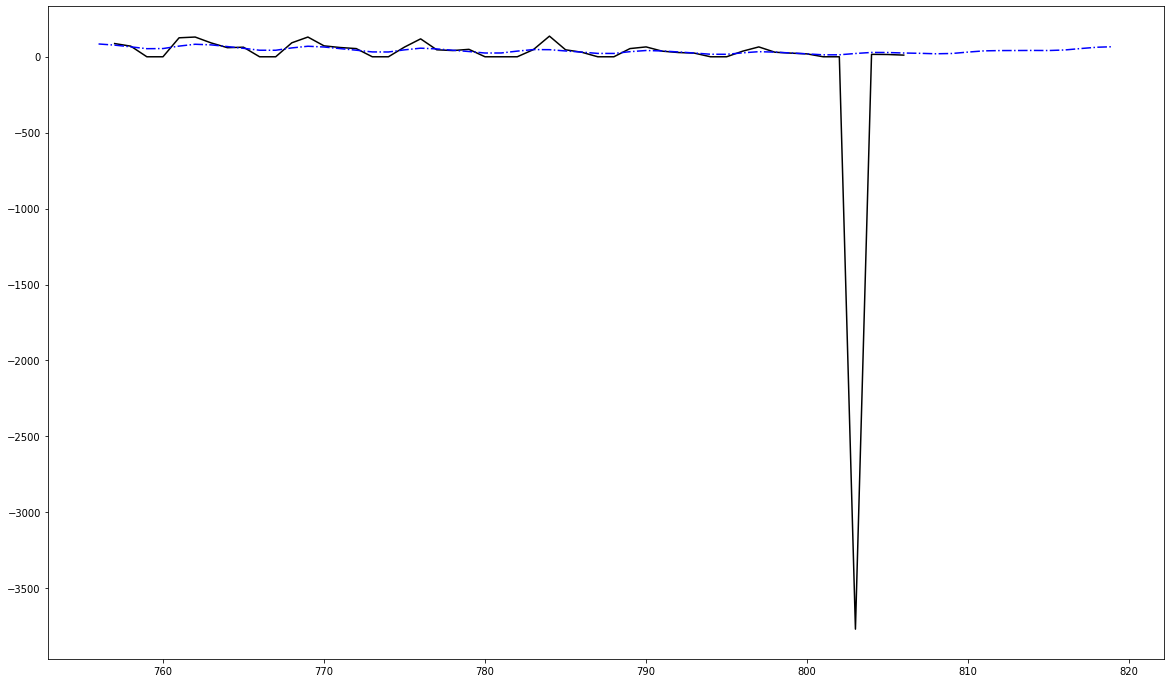

In [84]:
plot_predictions("Massachusetts", smooth_weight=1200, holdout_before="2021-11-01")

2020-01-01 00:00:00
2022-07-19 00:00:00
None
None
made matrix system ((34396, 1), (34396, 120))
Solved matrix system
sum(c) is [0.00865886]
expected days is [51.68173636]


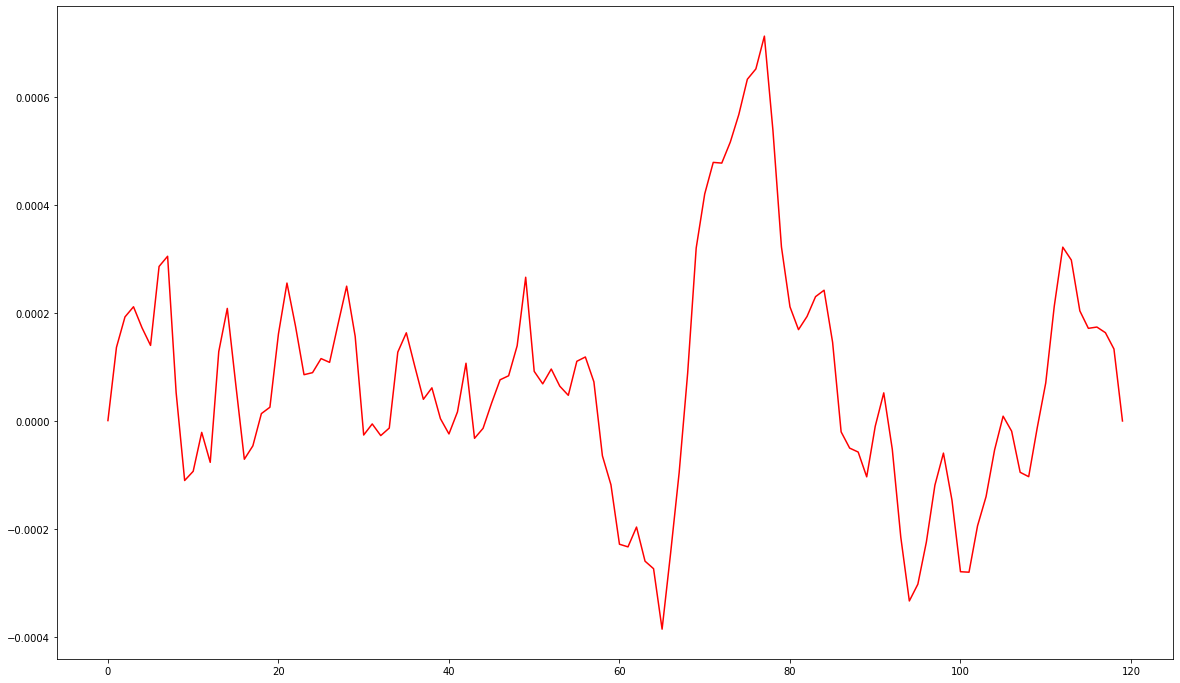

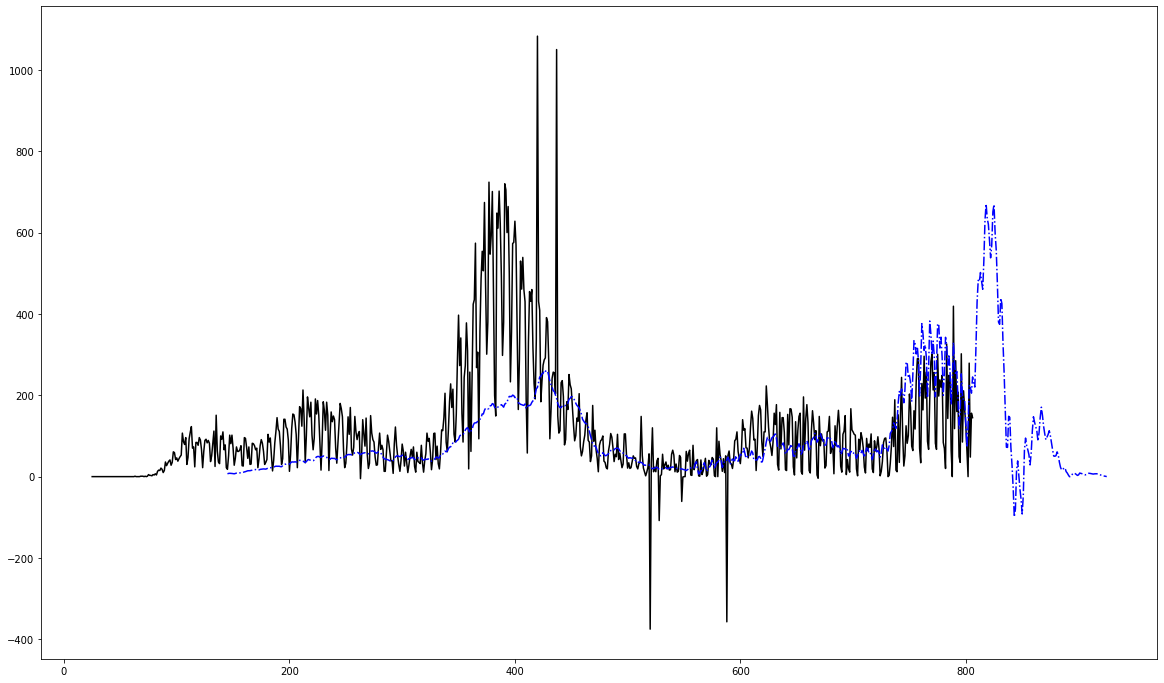

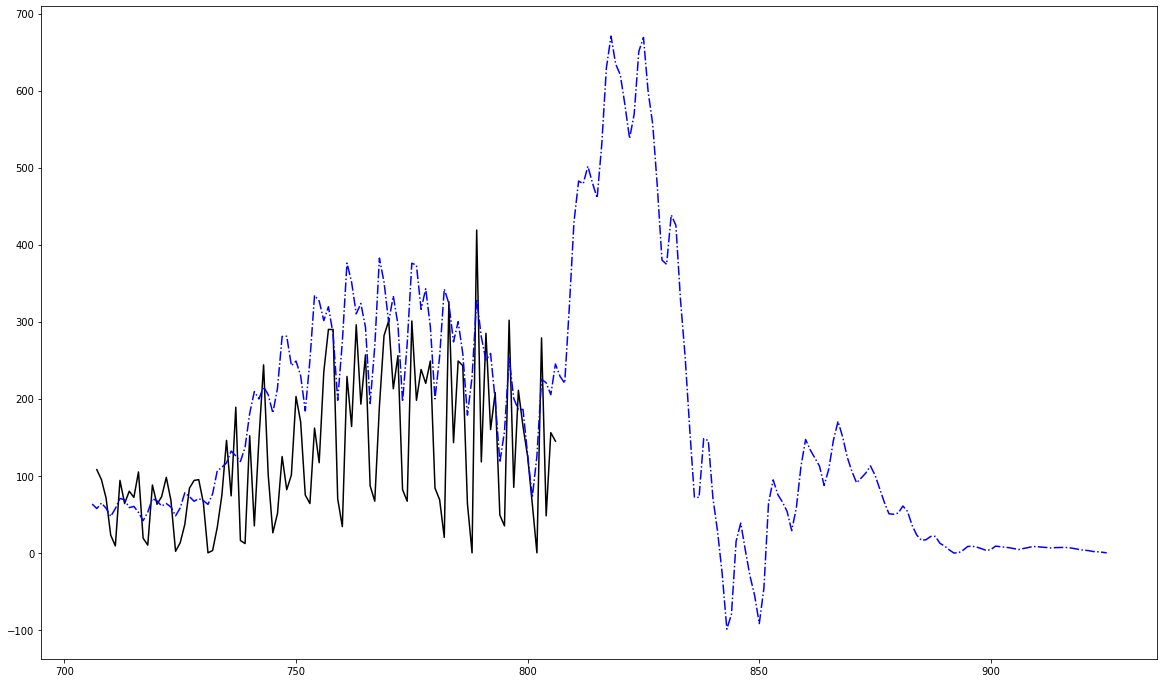

Today's date, 2022-03-18 is day number 807


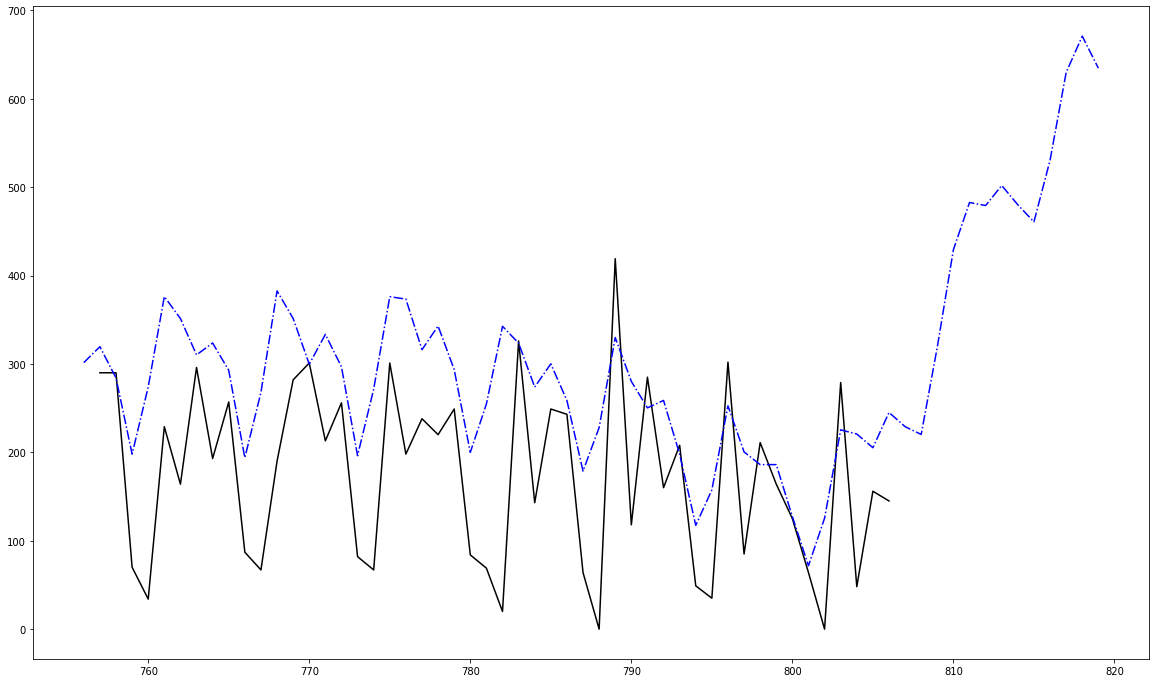

In [85]:
plot_predictions("California", smooth_weight=1200)

2020-01-01 00:00:00
2022-03-17 00:00:00
2021-12-01
None
made matrix system ((5797, 1), (5797, 20))
Solved matrix system
sum(c) is [0.0033978]
expected days is [14.32841504]


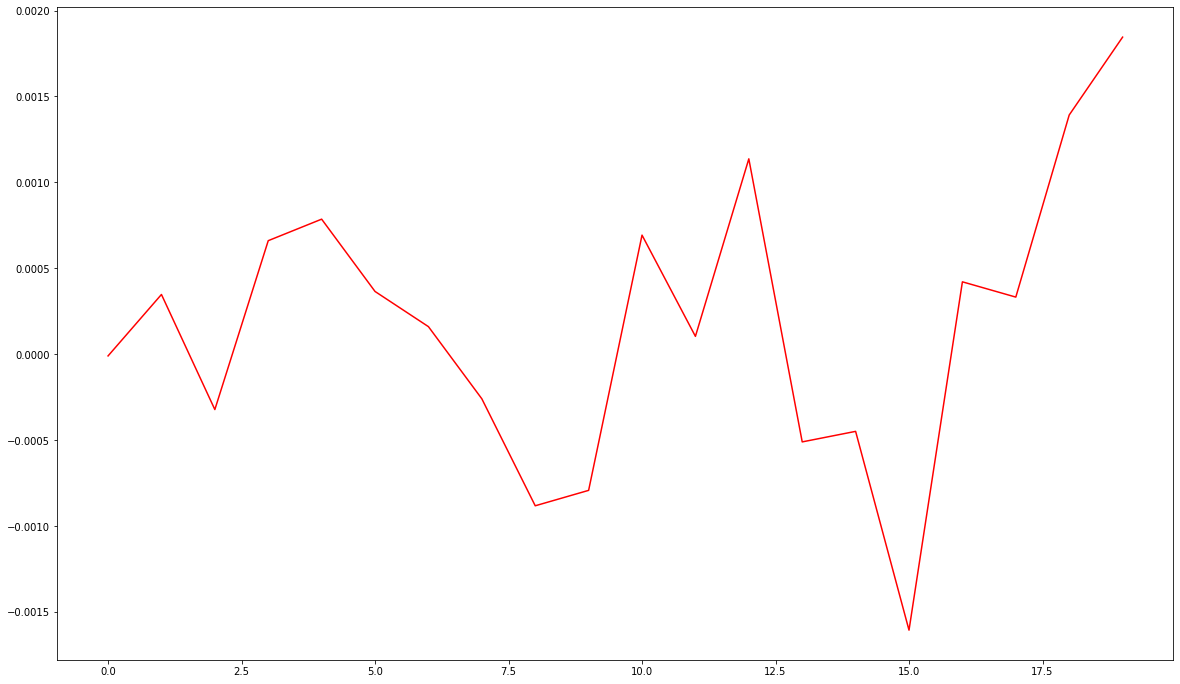

In [86]:
c_ny = solve_state("New York", smooth_weight=0.0012, end_smooth=0.0012, window=20, startdate="2021-12-01")
# Once we have enough omicron deaths, this line should model omicron
# I'm not sure that I trust it yet

2020-01-01 00:00:00
2023-06-12 00:00:00
None
None
made matrix system ((35455, 1), (35455, 120))
Solved matrix system
sum(c) is [0.00810195]
expected days is [48.55832931]


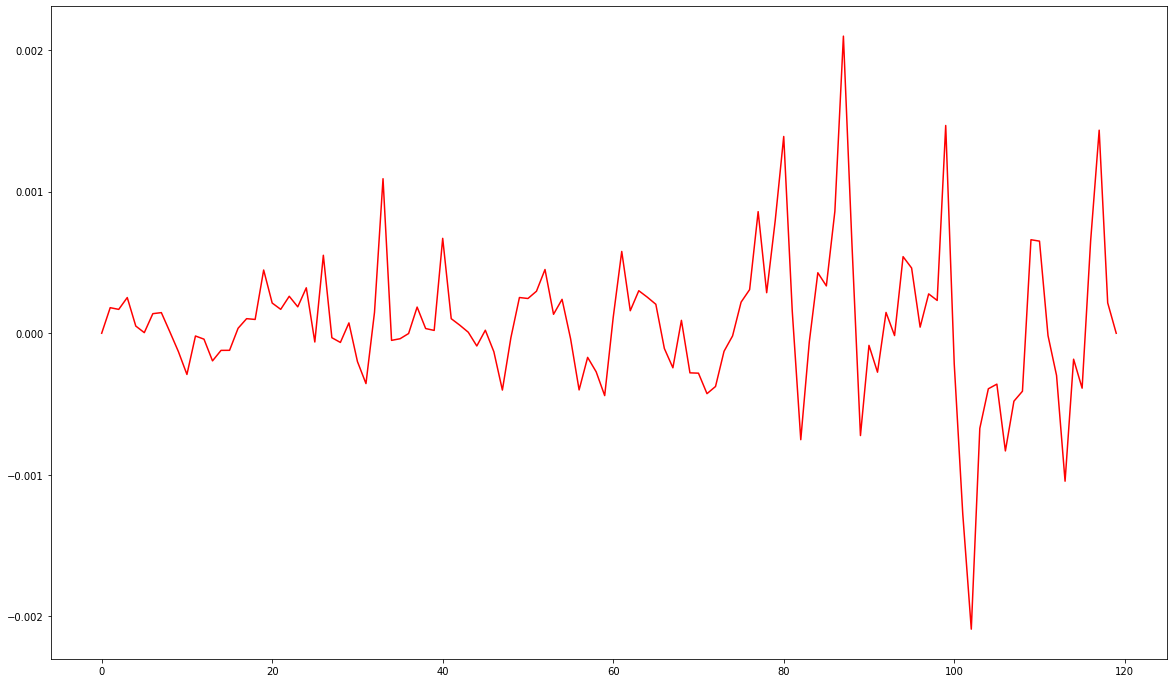

In [87]:
c_fl = solve_state("Florida", smooth_weight=200)

2020-01-01 00:00:00
2023-06-12 00:00:00
None
None
made matrix system ((35455, 1), (35455, 120))
Solved matrix system
sum(c) is [0.00802794]
expected days is [48.50419737]


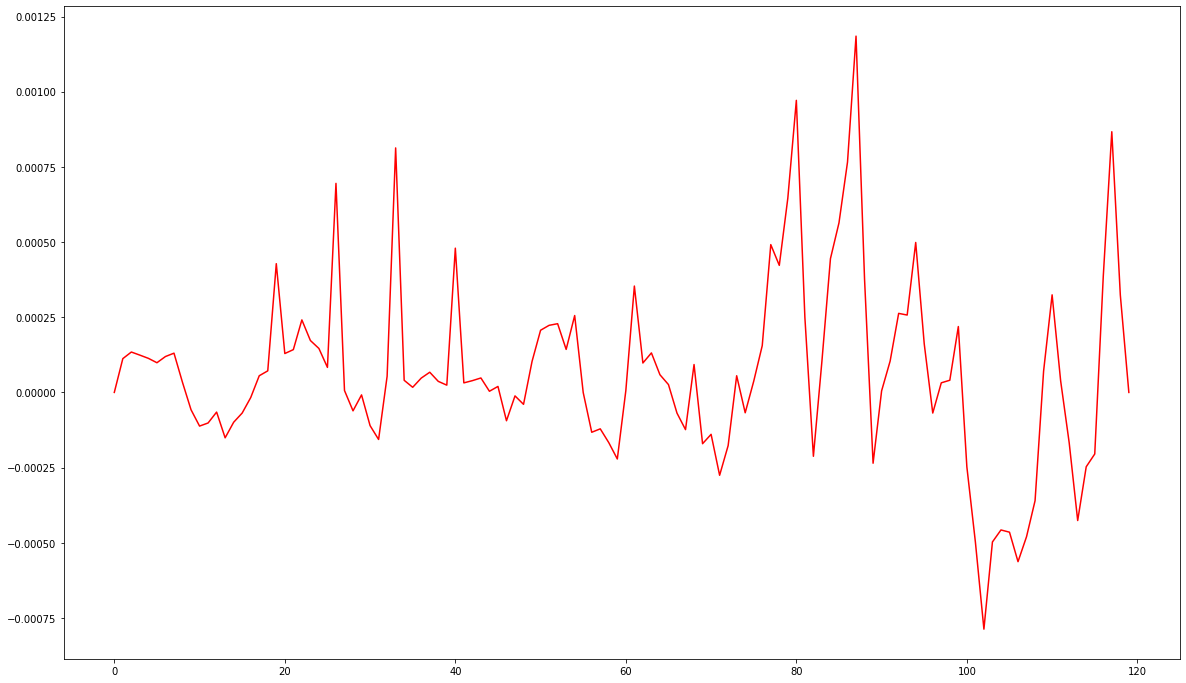

In [88]:
c_fl = solve_state("Florida", smooth_weight=500)

2020-01-01 00:00:00
2023-06-12 00:00:00
None
None
made matrix system ((35455, 1), (35455, 120))
Solved matrix system
sum(c) is [0.00787719]
expected days is [48.4528501]


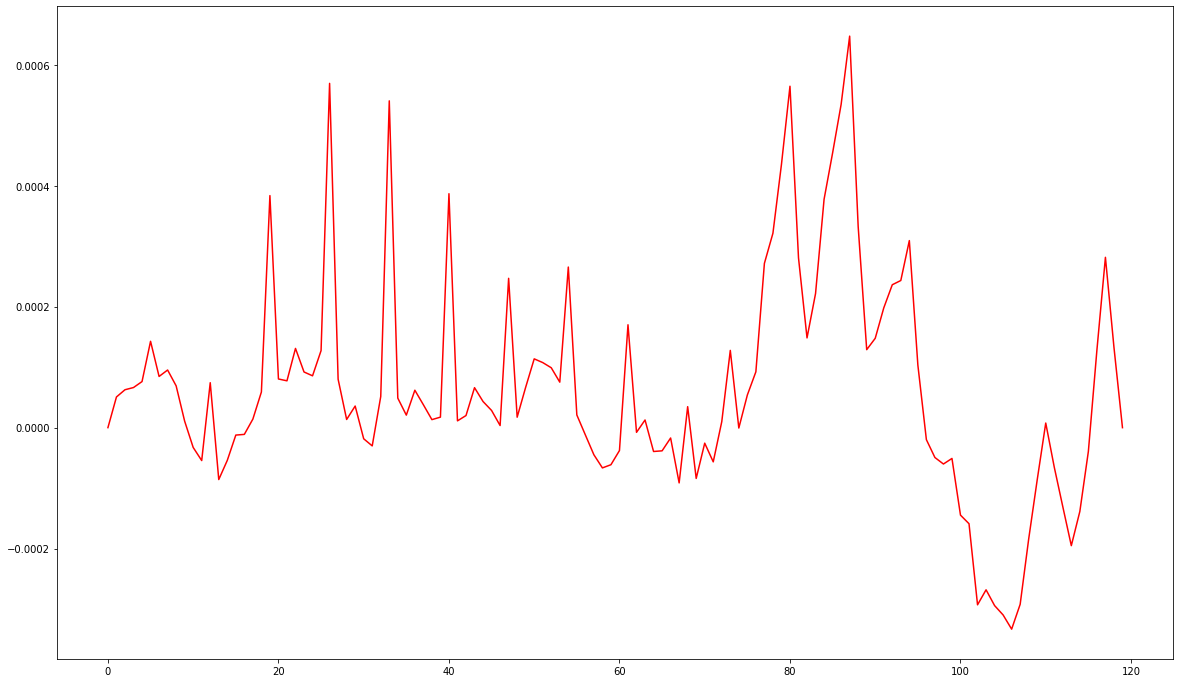

In [89]:
c_fl = solve_state("Florida", smooth_weight=1200)

2020-01-01 00:00:00
2022-03-17 00:00:00
None
None
made matrix system ((9434, 1), (9434, 120))
Solved matrix system
sum(c) is [0.01077911]
expected days is [25.91211814]


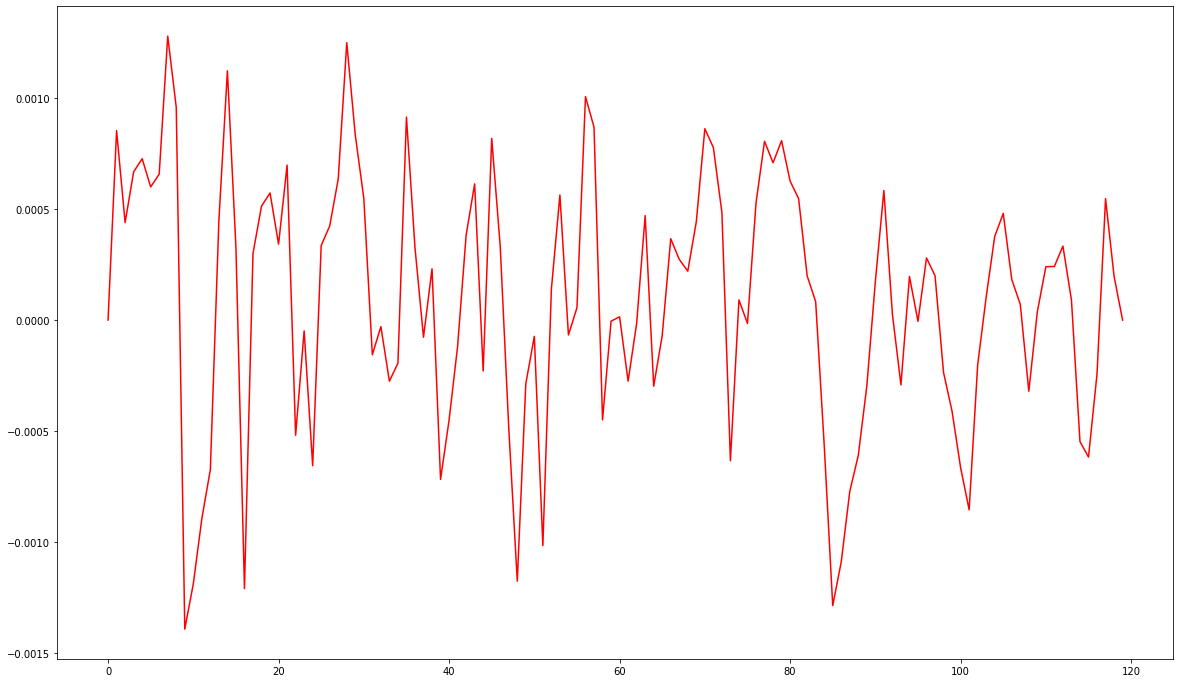

In [90]:
c_az = solve_state("Arizona", smooth_weight=200)

2020-01-01 00:00:00
2022-03-17 00:00:00
None
None
made matrix system ((9434, 1), (9434, 120))
Solved matrix system
sum(c) is [0.01070642]
expected days is [26.6745334]


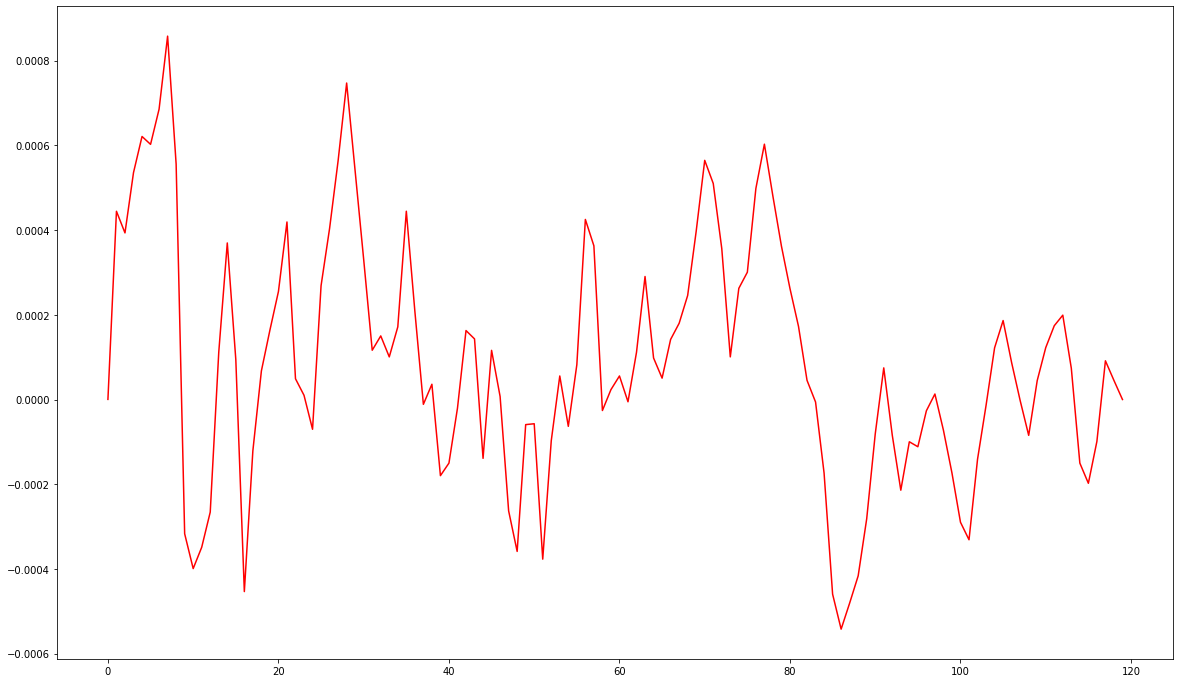

In [91]:
c_az = solve_state("Arizona", smooth_weight=500)

2020-01-01 00:00:00
2022-03-17 00:00:00
None
None
made matrix system ((9434, 1), (9434, 120))
Solved matrix system
sum(c) is [0.01064828]
expected days is [27.70213516]


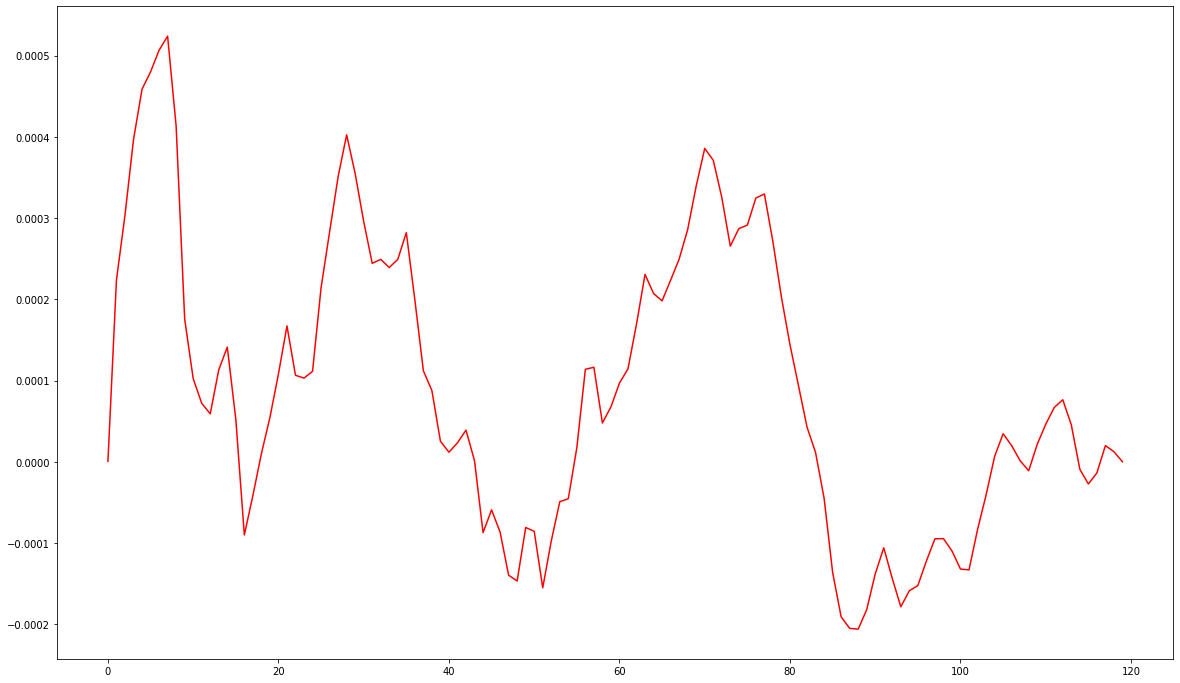

In [92]:
c_az = solve_state("Arizona", smooth_weight=1200)

2020-01-01 00:00:00
2022-03-17 00:00:00
None
None
made matrix system ((10270, 1), (10270, 120))
Solved matrix system
sum(c) is [0.0104914]
expected days is [26.71341336]


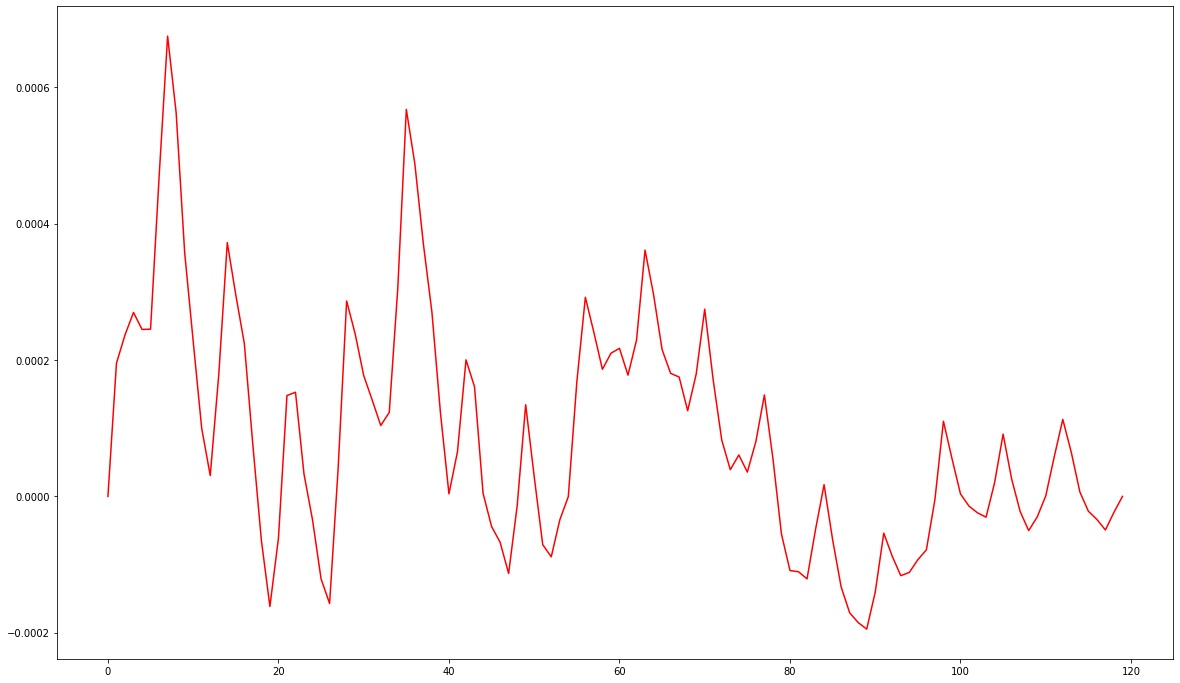

In [93]:
c_nm = solve_state("New Mexico", smooth_weight=200)

2020-01-01 00:00:00
2022-03-17 00:00:00
None
None
made matrix system ((10270, 1), (10270, 120))
Solved matrix system
sum(c) is [0.01037682]
expected days is [27.63106598]


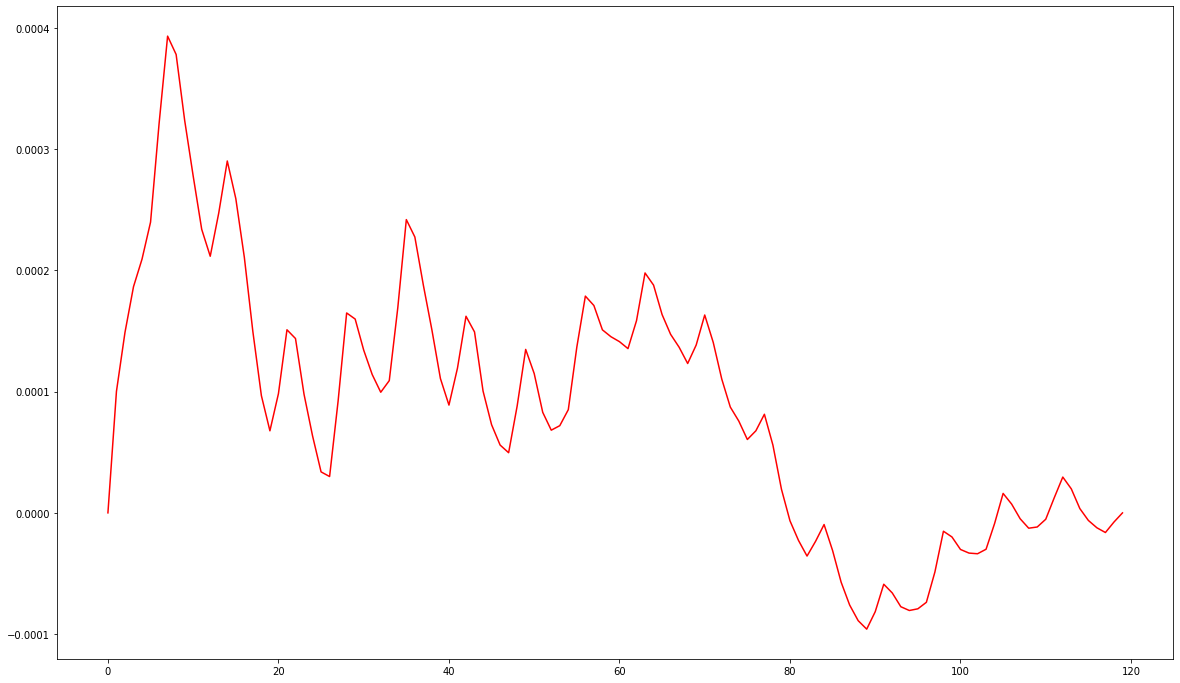

In [94]:
c_nm = solve_state("New Mexico", smooth_weight=500)

2020-01-01 00:00:00
2022-03-17 00:00:00
None
None
made matrix system ((10270, 1), (10270, 120))
Solved matrix system
sum(c) is [0.01055034]
expected days is [26.33078707]


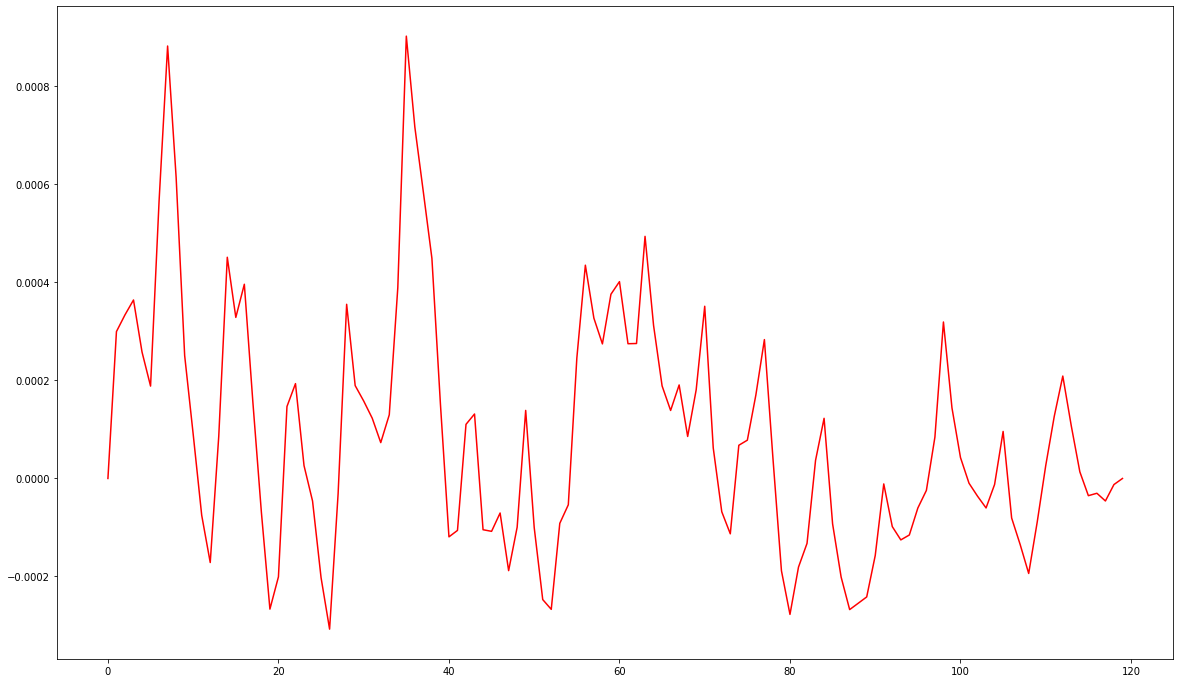

In [95]:
c_nm = solve_state("New Mexico", smooth_weight=100)

2020-01-01 00:00:00
2022-03-17 00:00:00
None
None
made matrix system ((10270, 1), (10270, 120))
Solved matrix system
sum(c) is [0.01060894]
expected days is [26.31652252]


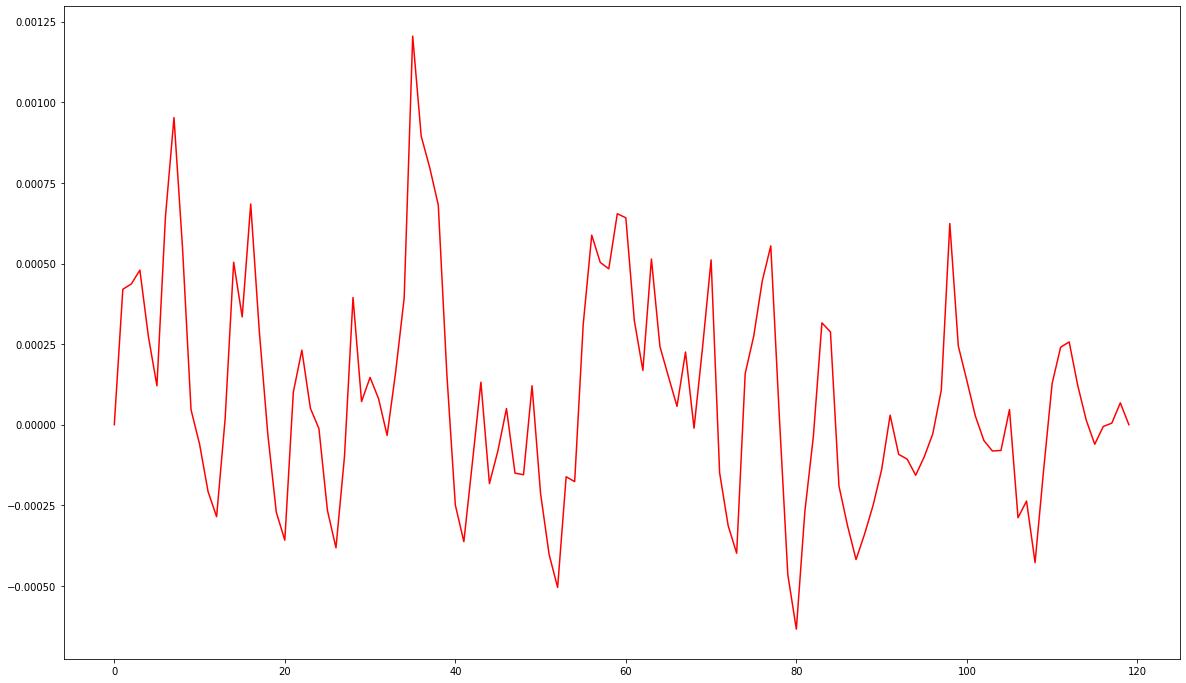

In [96]:
c_nm = solve_state("New Mexico", smooth_weight=50)